## Code to geerate some toy data to test for selection effects

The aim of this code is to generate radio luminosities ffrom the luminosity function of SF galaxies and then generate LIR according to some known model of the FIRC. I can then apply some selection effects to this simulated data to see the effect it has on my results.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,lognorm
import scipy.integrate as integrate
from scipy.stats import norm
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from numpy.random import normal
from random import randint

from astropy.table import Table,Column
from lifelines import KaplanMeierFitter
#import emcee
import time
#import corner
import herschelhelp
from matplotlib.colors import LogNorm
from astropy.stats import bootstrap

In [2]:
plt.rcParams['font.size']=10

In [3]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [4]:
def power_law(x,N,a):
    y = N * (1+x)**a
    return(y)

In [77]:
def fit_func(x,a,b,c):
    y = 1/(b*x**a) + c
    return(y)

In [5]:
def agn_luminosity_function(L):
    #returns N for the luminsity function from Heckman and Best 2014 page 615
    A = 10**(-5.33)
    P0 = 10**24.95
    alpha = 0.42
    beta = 1.66
    
    N = A/((L/P0)**alpha + (L/P0)**beta)
    return(N)

In [6]:
def sf_luminosity_function(L):
    #returns the luminosity function from Mauch and Sadler 2007
    C = 10**(-2.83)
    P0 = 10**(21.18)
    sig = 0.6
    alpha = 1.02
    
    N = C*(L/P0)**(1-alpha) * np.exp(-0.5*((np.log10(1+L/P0)/sig)**2))
    return(N)

In [7]:
def mcmc_sample_from_pdf(func,N,xmin,xmax,ymin,ymax):
    x = []
    for n in range(N):
        x.append(random.random())
    x = np.array(x)
    x = x+xmin + (x*(xmax-xmin))

    y = []
    for n in range(N):
        y.append(random.random())
    y = np.array(y)
    y = y+ymin + (y*(ymax-ymin))
    
    test = func(10**x)
    mask = y<np.log10(test)
    
    return(x[mask])

In [8]:
def generate_q(n,width,dist_type='norm',width_2=0,ratio=1,location=[0],normalisation=0):
    if dist_type=='norm':
        num = int(n*ratio)
        loc = location[0]
        scatter = norm.rvs(loc,width,size=num)
    if dist_type=='double_norm':
        num = int(np.round(n*ratio))
        loc = location[0]
        print(width,num)
        scatter_1 = norm.rvs(loc,width,size=num)
        
        num = int(np.round(n*(1-ratio)))
        loc = location[1]
        scatter_2 = norm.rvs(loc,width_2,size=num)
        
        scatter = np.append(scatter_1,scatter_2)
    if dist_type=='lognorm':
        #good width is 0.4
        scatter = -lognorm.rvs(width,size=n)
        bins = np.arange(-4,4,0.1)
        nums,_ = np.histogram(scatter,bins=bins)
        mode = bins[np.argmax(nums)]
        # thw plus two is to put the distribution 
        scatter = scatter - mode+0.05 + normalisation
    
    return(scatter)

In [9]:
def generate_q_z_evo(n,width,z,N,a,dist_type='norm',normalisation=0):
    z_evo_const = N*(1+z)**a
    if dist_type=='norm':
        scat = norm.rvs(0,width,size=n)
        scatter = scat + z_evo_const
    if dist_type=='lognorm':
        #good width is 0.4
        scatter = -lognorm.rvs(width,size=n)
        bins = np.arange(-4,4,0.1)
        nums,_ = np.histogram(scatter,bins=bins)
        mode = bins[np.argmax(nums)]
        # thw plus two is to put the distribution 

        scatter = scatter + z_evo_const + normalisation - mode
    
    return(scatter)

In [10]:
def create_ssfr_mask(z,ssfr):
    #create a mask to select SF galaxies based on their distance to the main sequence
    #any galaxy less that 0.3 dex below the main sequnce is counted as a SF galaxy
    # main sequnce equation taken from Sargent et al 2012
    
    # NOTE SSFR MUST BE GIVEN IN LOG FORM
    x = np.arange(0,1,0.0001)
    main_sequnce = np.log10(power_law(x,1,2.8)) - np.log10(5E10) - 0.3
    ssfr_limit = np.interp(z,x,main_sequnce)
    mask = (ssfr>=ssfr_limit) & ~np.isnan(ssfr)
    
    return(mask)

In [11]:
def linear_fit(x,m,c):
    y = m*x + c
    return(y)

In [12]:
x = bethermin_table['REDSHIFT']
y = np.log10(bethermin_table['SFR']/bethermin_table['MSTAR'])
plt.scatter(x,y,s=1,alpha=0.1)

x = np.arange(0,1,0.0001)
main_sequnce = np.log10(power_law(x,1,2.8)) - np.log10(5E10) - 0.3
plt.plot(x,main_sequnce,c='red')
plt.xlim(0,1)
plt.show()

NameError: name 'bethermin_table' is not defined

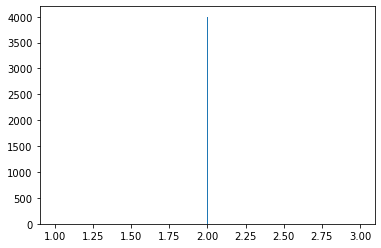

2.0 2.0 0.0


In [13]:
#Test generate_q_z_evo to see the scatter that a gaussian gives when bootstrapping a sample of 100000 galaxies
#into samples of 4000 (which match the number of real galaxies observed by LOFAR in EN1)
N = 2.0
q = generate_q_z_evo(100000,0,0,N,-0.2,dist_type='norm')

bootstrap_q = bootstrap(q,1000,4000)
medians = np.median(bootstrap_q,axis=0)

plt.hist(medians,bins=np.arange(1,3,0.005))
plt.show()
print(np.mean(medians),np.median(medians),np.std(medians))

In [14]:
def LIR_from_radio(lradio,dist_type='norm'):
    q = 2 + generate_q(len(lradio),dist_type=dist_type)
    
    logLIR = q + np.log10(lradio) + np.log10(3.75E12)
    LIR = 10**logLIR
    
    return(LIR)

In [15]:
def assign_redshift(n):
    #This function assigns each of my galaxies a redshift where the redshifts are drawn 
    #from the redshift distribution of my mass complete sample
    
    lofar_table = Table.read('data/lofar_sed_en1.fits')
    mass_complete_mask = (lofar_table['Z_BEST']<1.0) & (lofar_table['Mass_median']>10.7)
    redshifts = lofar_table[mass_complete_mask]['Z_BEST']
    
    bins = np.arange(0,1,0.01)
    centers = get_center(bins)
    nums,_ = np.histogram(redshifts,bins=bins)
    plt.hist(redshifts,bins=bins)
    plt.show()
    
    y = np.cumsum(nums)
    
    #do MCMC sampling to get redshifts from the distribution
    x = []
    for m in range(n):
        x.append(random.random())
    z = np.interp(x,y/np.max(y),centers)
    
    return(z)
        
    

In [16]:
def calc_Q(l_fir,l_rad):
    Q = np.log10(l_fir/3.75E12) - np.log10(l_rad)
    return(Q)

In [17]:
lofar_sed_en1 = Table.read('data/lofar_sed_en1.fits')
print(len(lofar_sed_en1))
lofar_sed_en1[0]

31602


Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,SFR_bayes,chi2,chi2_99_flag,LIR_8_1000_med,LIR_8_1000_p16,LIR_8_1000_p84,LIR_8_1000_ml,LIR,LIR_em,LIR_ep,logL150,goodAF,ln_l,q150,radio_luminosity,q_magphys,q_agnfitter,q_250,q_350,q_500,kcorr_250,kcorr_350,kcorr_500,Radio_ID,Spitzer_SN,Donley,Lacy,Stern,Messias,KI,Ch2_Ch4,Ch4_24mu,Xray,Opt_spec,AGNfrac_af,AGNfrac_af_16,AGNfrac_cg_s,AGNfrac_cg_s_16,AGNfrac_cg_f,AGNfrac_cg_f_16,Chi_sq_MpBp,Chi_sq_AfCg,AGN_final,Mass_conc,SFR_conc,Radio_excess,Radio_excess_DJS,Extended_radio,RadioAGN_final
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [18]:
stellar_mass_cat = Table.read('../../lofar/deep_fields/ELAIS-N1/data/EN1_opt_spitzer_merged_vac_opt3as_irac4as_all_hpx_masses_public.fits')

mask = (stellar_mass_cat['Z_BEST']<1.0) & (stellar_mass_cat['Mass_median']>10.7)
print('there are {} sources with M>10.7 and z<1.0'.format(np.sum(mask)))

there are 29329 sources with M>10.7 and z<1.0


In [19]:
lofar_magphys_en1 = Table.read('data/magphys_mass_radio_limits_en1.fits')
#mask = lofar_magphys_en1['q_lim']==1E20
#lofar_magphys_en1['q_lim'][mask] = np.nan
print(len(lofar_magphys_en1))
lofar_magphys_en1[0]

146996


ID,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98,ID_OPTICAL,ID_SPITZER,RA,DEC,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,FLAG_OVERLAP,FLAG_CLEAN,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,radio_flux_pixel,radio_flux_limit,radio_luminosity_pixel,radio_luminosity_limit,q_pixel,q_lim,q_250_lim,q_350_lim,q_500_lim,kcorr_250,kcorr_350,kcorr_500
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,deg,deg,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,solMass,solMass,solMass,solMass / yr,solMass 

In [20]:
#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

#mask_loc = (lofar_sed_en1['RA']>242.5) & (lofar_sed_en1['RA']<243.5) & (lofar_sed_en1['DEC']>54) & (lofar_sed_en1['DEC']<56) 
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (lofar_sed_en1['Mass_median']>10.7)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - lofar_sed_en1['Mass_median'] - np.log10(3.8*10**26))>-10.5
#ssfr = (np.log10(lofar_sed_en1['SFR_bayes']) - lofar_sed_en1['Mass_median'] - np.log10(3.8*10**26))
#SSFR_mask = create_ssfr_mask(lofar_sed_en1['Z_BEST'],ssfr)
detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_sample_en1)))



mask_loc = (lofar_magphys_en1['RA']>242.5) & (lofar_magphys_en1['RA']<243.5) & (lofar_magphys_en1['DEC']>54) & (lofar_magphys_en1['DEC']<56)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (lofar_magphys_en1['Mass_median']>10.7)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - lofar_magphys_en1['Mass_median'])>-10.5
#ssfr = (np.log10(lofar_magphys_en1['SFR_bayes']) - lofar_magphys_en1['Mass_median'])
#SSFR_mask = create_ssfr_mask(lofar_magphys_en1['Z_BEST'],ssfr)
limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_sample_en1)))

There are 0 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 5240 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


In [21]:
#needed if using the old fits file that is incomplete
'''bethermin_sim = Table.read('../../simulations/bethermin/Mock_cat_Bethermin2017.fits')
col_names = bethermin_sim.colnames
bethermin_table = Table.read('../../simulations/bethermin/SIDES_Bethermin2017.fits')
bethermin_table = Table()
for n,name in enumerate(bethermin_sim.colnames):
    col = Column(data=bethermin_sim[name][0],name=name)
    bethermin_table.add_column(col)
bethermin_table[:5]'''

"bethermin_sim = Table.read('../../simulations/bethermin/Mock_cat_Bethermin2017.fits')\ncol_names = bethermin_sim.colnames\nbethermin_table = Table.read('../../simulations/bethermin/SIDES_Bethermin2017.fits')\nbethermin_table = Table()\nfor n,name in enumerate(bethermin_sim.colnames):\n    col = Column(data=bethermin_sim[name][0],name=name)\n    bethermin_table.add_column(col)\nbethermin_table[:5]"

In [22]:
col_remove = ['col22','col28','col29','col1']

bethermin_sim = Table.read('../../simulations/bethermin/Mock_cat_Bethermin2017.fits')
col_names = bethermin_sim.colnames
bethermin_table = Table.read('../../simulations/bethermin/SIDES_Bethermin2017.fits')
bethermin_table.remove_columns(col_remove)
for n,name in enumerate(bethermin_table.colnames):
    bethermin_table[name].name = col_names[n]
bethermin_table[:5]

REDSHIFT,RA,DEC,MHALO,MSTAR,QFLAG,SFR,MU,ISSB,UMEAN,SMIPS24,SPACS70,SPACS100,SPACS160,SSPIRE250,SSPIRE350,SSPIRE500,SNIKA1200,SNIKA2000,S200,S450,S750,S850,S1100,S1300,SSPIRE250EXT,SSPIRE350EXT,SSPIRE500EXT
float64,float64,float64,float64,float64,int16,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.027082,1.386314,0.578664,975516200000.0,11660010000.0,1,0.0,0.99064320326,0,4.0340633392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.029516,0.454959,1.145274,969336300000.0,26126700000.0,1,0.0,1.0009043217,0,5.0857095718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.028948,0.653517,1.053531,345811200000.0,4891516000.0,0,1.5437514782,1.0092240572,0,8.0576715469,0.031881753355,0.43114998937,0.63253998756,0.56240075827,0.25633311272,0.10461972654,0.037053782493,0.0024221730419,0.00062151113525,0.40018302202,0.051566097885,0.010986724868,0.0059967972338,0.0029990351759,0.0018128481461,0.24834792316,0.10036225617,0.034429177642
0.027158,0.931048,0.651234,347876100000.0,1876074000.0,0,0.385166049,0.99989718199,0,5.078807354,0.0067023513839,0.11593775451,0.19231434166,0.19347545505,0.096441268921,0.041178300977,0.015020783991,0.0009953668341,0.00023443372629,0.14515936375,0.020753141493,0.0045370478183,0.0024849998299,0.0012372544734,0.00073967792559,0.093633815646,0.03956316784,0.013976560906
0.028611,0.787421,0.940826,336224200000.0,1672992000.0,0,0.23426419497,0.9920681119,0,6.3991942406,0.0046839113347,0.064619034529,0.099355973303,0.093147851527,0.044217612594,0.018421644345,0.0066116498783,0.00043446887867,0.00010727281187,0.067906811833,0.0091717215255,0.0019761712756,0.0010800315067,0.00053893582663,0.00032408637344,0.042880933732,0.017684331164,0.0061471196823


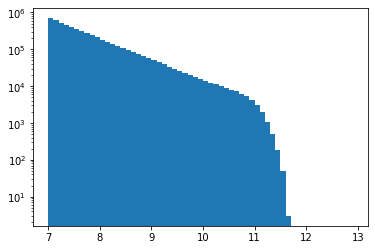

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


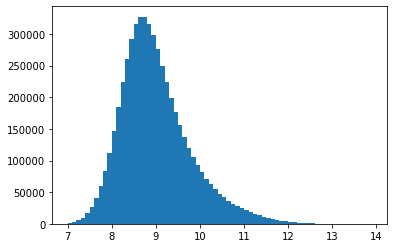

In [23]:
bins = np.arange(7,13,0.1)
plt.hist(np.log10(bethermin_table['MSTAR']),bins=bins,log=True)
plt.show()

bins = np.arange(7,14,0.1)
y = np.log10(bethermin_table['SFR'] / 1E-10)
plt.hist(y,bins=bins)
plt.show()

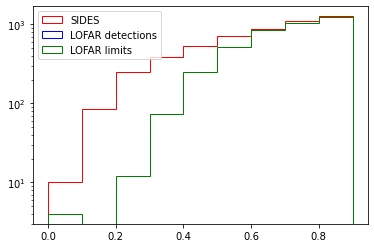

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


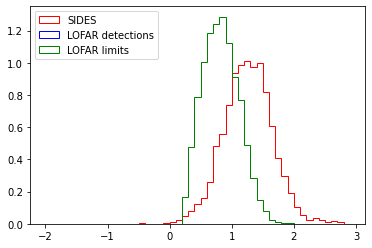

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


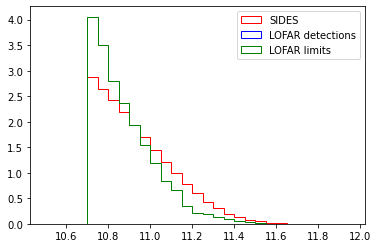

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log10
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


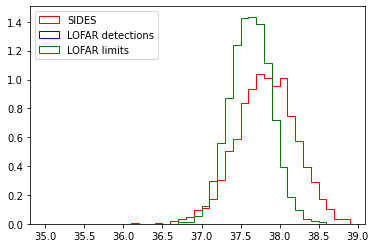

In [24]:
#Compare the SIDES simulation properties with the real LOFAR data

#limit the sides simulation to the same selection criteria as my sample
ssfr = bethermin_table['SFR']/bethermin_table['MSTAR']
mask_ssfr = create_ssfr_mask(bethermin_table['REDSHIFT'],ssfr)
mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7) & (mask_ssfr)

#N(z)
bins = np.arange(0,1,0.1)
z = bethermin_table['REDSHIFT'][mask_mass]
plt.hist(z,bins=bins,label='SIDES',histtype='step',color='red',log=True)

z = detected_sample_en1['Z_BEST']
plt.hist(z,bins=bins,label='LOFAR detections',histtype='step',color='blue',log=True)

z = limit_sample_en1['Z_BEST']
plt.hist(z,bins=bins,label='LOFAR limits',histtype='step',color='green',log=True)

plt.legend(loc='upper left')
plt.show()

#N(SFR)
bins = np.arange(-2,3,0.1)
z = np.log10(bethermin_table['SFR'][mask_mass])
plt.hist(z,bins=bins,density=True,label='SIDES',histtype='step',color='red')

z = np.log10(detected_sample_en1['SFR_bayes']) - np.log10(3.8E26)
plt.hist(z,bins=bins,density=True,label='LOFAR detections',histtype='step',color='blue')

z = np.log10(limit_sample_en1['SFR_bayes'])
plt.hist(z,bins=bins,density=True,label='LOFAR limits',histtype='step',color='green')

plt.legend(loc='upper left')
plt.show()

#N(M)
bins = np.arange(10.5,12,0.05)
z = np.log10(bethermin_table['MSTAR'][mask_mass])
plt.hist(z,bins=bins,density=True,label='SIDES',histtype='step',color='red')

z = detected_sample_en1['Mass_median']
plt.hist(z,bins=bins,density=True,label='LOFAR detections',histtype='step',color='blue')

z = limit_sample_en1['Mass_median']
plt.hist(z,bins=bins,density=True,label='LOFAR limits',histtype='step',color='green')

plt.legend()
plt.show()

#N(LIR)
bins = np.arange(35,39,0.1)
z = np.log10( (bethermin_table['SFR'] / 1E-10 * 3.8E26) [mask_mass])
plt.hist(z,bins=bins,density=True,label='SIDES',histtype='step',color='red')

z = np.log10(detected_sample_en1['Ldust_bayes'])
plt.hist(z,bins=bins,density=True,label='LOFAR detections',histtype='step',color='blue')

z = np.log10(limit_sample_en1['Ldust_bayes'])
plt.hist(z,bins=bins,density=True,label='LOFAR limits',histtype='step',color='green')

plt.legend(loc='upper left')
plt.show()

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


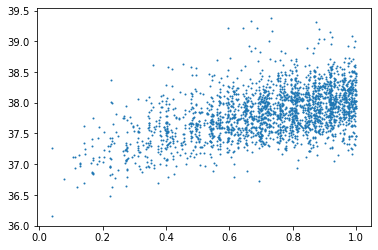

In [25]:
x = bethermin_table['REDSHIFT'][mask_mass]
y = np.log10(bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26)
plt.scatter(x,y,s=1)

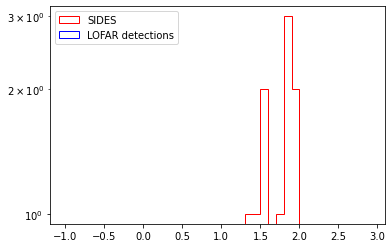

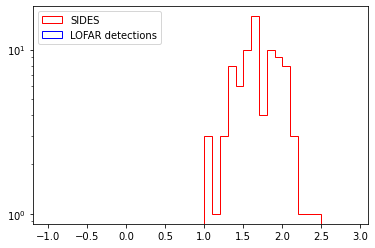

In [26]:
#Compare the SIDES simulation properties with the real LOFAR data
lir = bethermin_table['SFR'] / 1E-10 * 3.8E26
z = bethermin_table['REDSHIFT']
#limit the sides simulation to the same selection criteria as my sample
mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7)

#N(z)
bins_z = np.arange(0,0.3,0.1)
for n in range(len(bins_z)-1):
    bins = np.arange(-1,3,0.1)
    
    mask_z = (bethermin_table['REDSHIFT']>bins_z[n]) & (bethermin_table['REDSHIFT']<bins_z[n+1])
    z = generate_q(len(lir),0.3,dist_type='norm',normalisation=1.65,location=[1.7])[mask_mass & mask_z]
    plt.hist(z,bins=bins,label='SIDES',histtype='step',color='red',log=True)

    mask_z = (detected_sample_en1['Z_BEST']>bins_z[n]) & (detected_sample_en1['Z_BEST']<bins_z[n+1])
    z = detected_sample_en1['q_magphys'][mask_z]
    plt.hist(z,bins=bins,label='LOFAR detections',histtype='step',color='blue',log=True)

    mask_z = (limit_sample_en1['Z_BEST']>bins_z[n]) & (limit_sample_en1['Z_BEST']<bins_z[n+1])
    z = limit_sample_en1['q_lim'][mask_z]
    #plt.hist(z,bins=bins,label='LOFAR limits',histtype='step',color='green',log=True)

    plt.legend(loc='upper left')
    plt.show()

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


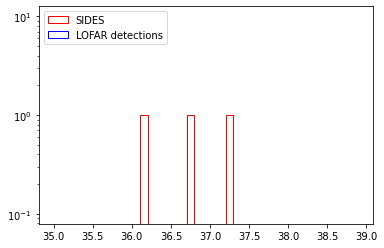

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


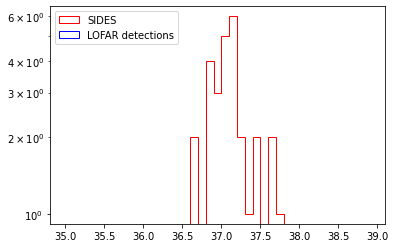

In [27]:
#Compare the SIDES simulation properties with the real LOFAR data
lir = bethermin_table['SFR'] / 1E-10 * 3.8E26
z = bethermin_table['REDSHIFT']
#limit the sides simulation to the same selection criteria as my sample
mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7)

#N(z)
bins_z = np.arange(0,0.3,0.1)
for n in range(len(bins_z)-1):
    bins = np.arange(35,39,0.1)
    
    mask_z = (bethermin_table['REDSHIFT']>bins_z[n]) & (bethermin_table['REDSHIFT']<bins_z[n+1])
    z = np.log10(lir[mask_mass & mask_z])
    plt.hist(z,bins=bins,label='SIDES',histtype='step',color='red',log=True)

    mask_z = (detected_sample_en1['Z_BEST']>bins_z[n]) & (detected_sample_en1['Z_BEST']<bins_z[n+1])
    z = np.log10(detected_sample_en1['Ldust_bayes'][mask_z])
    plt.hist(z,bins=bins,label='LOFAR detections',histtype='step',color='blue',log=True)

    mask_z = (limit_sample_en1['Z_BEST']>bins_z[n]) & (limit_sample_en1['Z_BEST']<bins_z[n+1])
    z = np.log10(limit_sample_en1['Ldust_bayes'][mask_z])
    #plt.hist(z,bins=bins,label='LOFAR limits',histtype='step',color='green',log=True)

    plt.legend(loc='upper left')
    plt.show()

In [27]:
ssfr = bethermin_table['SFR']/bethermin_table['MSTAR']
mask_ssfr = create_ssfr_mask(bethermin_table['REDSHIFT'],ssfr)
mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7) & mask_ssfr
z = bethermin_table['REDSHIFT'][mask_mass]
dist = cosmo.luminosity_distance(z).to(u.m).value

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


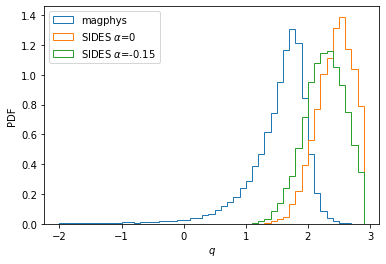

the SIDES median is: 2.302706289723069


In [28]:
#Generate q values for he SIDES simulation galaxies
q = lofar_sed_en1['q_magphys']#+2.7
bins=np.arange(-2,3,0.1)
plt.hist(q,bins=bins,histtype='step',density=True,label='magphys')

#mask = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7)
lir = bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26
q = generate_q_z_evo(len(bethermin_table[mask_mass]),0.35,z,2.5,0,dist_type='norm')
#q = generate_q_z_evo(len(bethermin_table[mask_mass]),0.35,z[mask_mass],1.8,0,dist_type='norm')
#q = generate_q(len(lir),0.24,dist_type='norm',width_2=0.5,ratio=0.65,location=[1.7,1.2])
lrad = 10**(np.log10(lir/3.75E12) - q)

#plt.hist(q,bins=bins,histtype='step',density=True,label='SIDES full')

y = q
plt.hist(y,bins=bins,histtype='step',density=True,label=r'SIDES $\alpha$=0')


lir = bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26
q = generate_q_z_evo(len(bethermin_table[mask_mass]),0.35,z,2.5,-0.15,dist_type='norm')
#q = generate_q_z_evo(len(bethermin_table[mask_mass]),0.35,z[mask_mass],1.8,0,dist_type='norm')
#q = generate_q(len(lir),0.24,dist_type='norm',width_2=0.5,ratio=0.65,location=[1.7,1.2])
lrad = 10**(np.log10(lir/3.75E12) - q)

#plt.hist(q,bins=bins,histtype='step',density=True,label='SIDES full')

y = q
plt.hist(y,bins=bins,histtype='step',density=True,label=r'SIDES $\alpha$=-0.15')

plt.xlabel('$q$')
plt.ylabel('PDF')
plt.legend(loc='upper left')
plt.savefig('../figures/plots/SIDES_q_comp.pdf',format='pdf')
plt.show()

print('the SIDES median is: {}'.format(np.median(q)))

There are 6565 galaxies in SIDES which meet the LOFAR selection criteria
the true mean of the generated q distribution for my mass selected sample is: 2.302706289723069
my selection median is:2.3327972471766976


/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


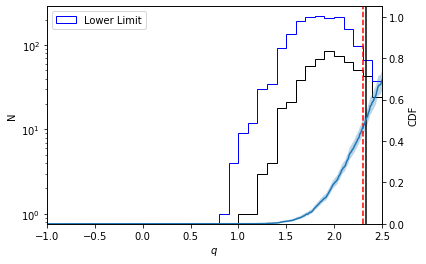

In [29]:
#Measure the median of the SIDES q values using survival analysis



alpha = -0.73
frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-alpha)) * 1E26 #get radio fluxes in Jy

mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7)
print('There are {} galaxies in SIDES which meet the LOFAR selection criteria'.format(np.sum(mask_mass)))
print('the true mean of the generated q distribution for my mass selected sample is: {}'.format(np.median(q)))
mask_rad_sel = (frad>1E-4)  

fig,ax1 = plt.subplots()

bins = np.arange(-2,4,0.1)
q_det = q[mask_rad_sel]
ax1.hist(q_det,bins=bins,log=True,histtype='step',color='black')

frad_lim = 1E-4 / 1E26
lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel]**2 * (1+z[~mask_rad_sel])**(-1-alpha))
q_lim = np.log10(lir[~mask_rad_sel]/3.75E12) - np.log10(lrad_lim)
ax1.hist(q_lim,bins=bins,log=True,histtype='step',label='Lower Limit',color='blue')

data = np.append(q_det,q_lim)
mask = ~np.isinf(data)
data = data[mask]
det = np.append(np.ones(len(q_det)),np.zeros(len(q_lim)))[mask]
data_z = np.append(z[mask_rad_sel],z[~mask_rad_sel])[mask]
kmf = KaplanMeierFitter() 
kmf.fit(data, det,label='Kaplan Meier Estimate')
print('my selection median is:{}'.format(kmf.median_survival_time_))

ax2 = ax1.twinx()
x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
y_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].values

x = np.arange(-1,3,0.01)
y = np.interp(x,x_kmf,y_kmf)
ax2.plot(x,y)
lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
lowx = np.interp(x,x_kmf,lowx_kmf)
upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
upx = np.interp(x,x_kmf,upx_kmf)
ax2.fill_between(x,lowx,upx,alpha=0.3)
ax2.set_ylabel('CDF')

plt.vlines(kmf.median_survival_time_,0,2000,label='Measured median',color='black')
plt.vlines(np.median(q),0,2000,label='True median',color='red',linestyle='dashed')
plt.ylim(0,1.05)
plt.xlim(-1,2.5)
ax1.set_xlabel('$q$')
ax1.set_ylabel('N')
ax1.legend(loc='upper left')
plt.savefig('../figures/plots/SIDES_q_hist.pdf',format='pdf')
plt.show()

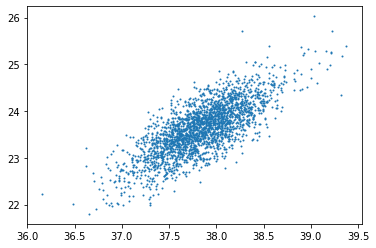

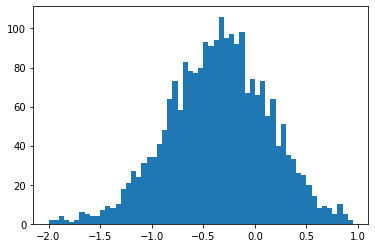

In [187]:
lir = bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26
lrad = 10**(np.log10(lir/3.75E12) - q)

plt.scatter(np.log10(lir),np.log10(lrad),s=1)
plt.show()



alpha = -0.73
frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-alpha)) * 1E26 #get radio fluxes in Jy

mask_rad_sel = (frad>1E-4)  

q_det_orig = q

frad_lim = 1E-4 / 1E26
lrad_lim = frad_lim * (4*np.pi*dist**2 * (1+z)**(-1-alpha))
q_lim_orig = np.log10(lir/3.75E12) - np.log10(lrad_lim)

y = q_det_orig - q_lim_orig
plt.hist(y,bins=np.arange(-2,1,0.05))
plt.show()

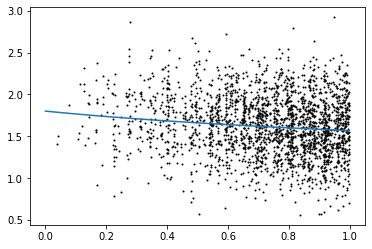

In [159]:
x = z
y = q
plt.scatter(x,y,c='black',s=1)

x = np.arange(0,1,0.001)
y = power_law(x,1.8,-0.2)
plt.plot(x,y)

There are 6565 galaxies in SIDES which meet the LOFAR selection criteria
There are 6018 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 19833 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


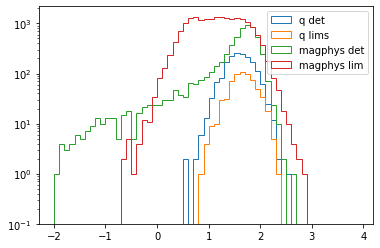

In [28]:
#check the simulated q distribution is similar to the magphys q
mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7)
print('There are {} galaxies in SIDES which meet the LOFAR selection criteria'.format(np.sum(mask_mass)))
mask_rad_sel = (frad>1E-4)  

bins = np.arange(-2,4,0.1)
q_det = q[mask_rad_sel & mask_mass]
plt.hist(q_det,bins=bins,log=True,histtype='step',label='q det')

frad_lim = 1E-4 / 1E26
lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel & mask_mass]**2 * (1+z[~mask_rad_sel & mask_mass])**(-1-alpha))
q_lim = np.log10(lir[~mask_rad_sel & mask_mass]/3.75E12) - np.log10(lrad_lim)
plt.hist(q_lim,bins=bins,log=True,histtype='step',label='q lims')

#plot the magphys q's
y = detected_sample_en1['q_magphys']
plt.hist(y,bins=bins,log=True,histtype='step',label='magphys det')

y = limit_sample_en1['q_lim']
plt.hist(y,bins=bins,log=True,histtype='step',label='magphys lim')

plt.legend()
plt.show()

90
111
----------


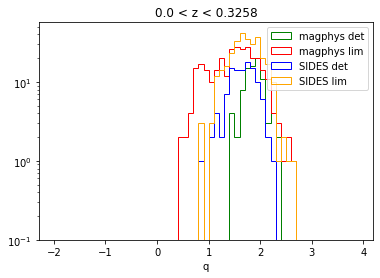

85
132
----------


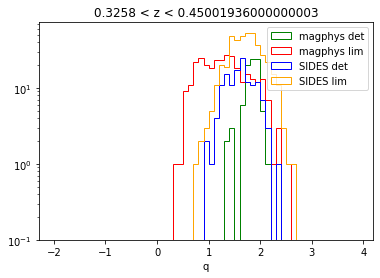

96
106
----------


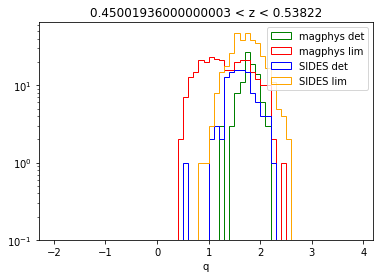

87
185
----------


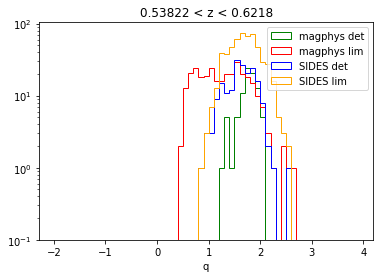

81
145
----------


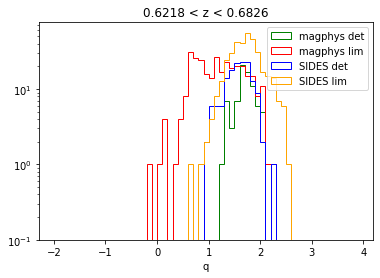

72
183
----------


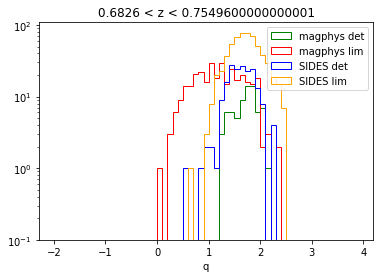

82
254
----------


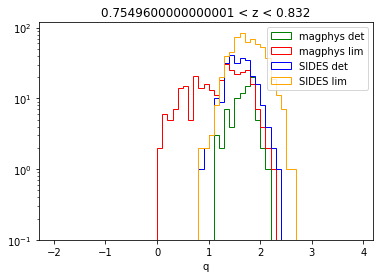

63
179
----------


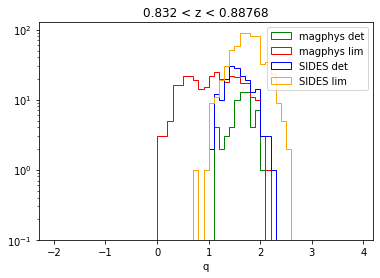

60
182
----------


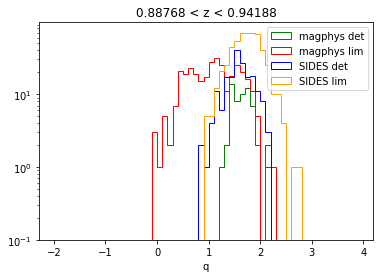

54
214
----------


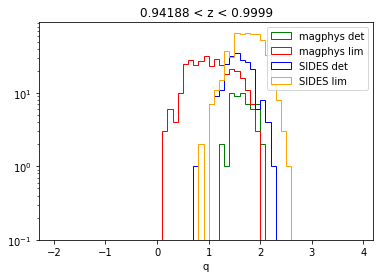

In [41]:
data_z = np.append(detected_sample_en1['Z_BEST'],limit_sample_en1['Z_BEST'])

bins_z = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(data_z,percent))
bins_z = np.array(bins_z)

for n,bin_edge in enumerate(bins_z[:-1]):
    bins = np.arange(-2,4,0.1)
    
    mask_z = (detected_sample_en1['Z_BEST']>=bins_z[n]) & (detected_sample_en1['Z_BEST']<=bins_z[n+1])
    y = detected_sample_en1['q_magphys'][mask_z]
    print(len(y))
    plt.hist(y,bins=bins,log=True,histtype='step',label='magphys det',color='green')
    
    mask_z = (limit_sample_en1['Z_BEST']>=bins_z[n]) & (limit_sample_en1['Z_BEST']<=bins_z[n+1])
    y = limit_sample_en1['q_lim'][mask_z]
    plt.hist(y,bins=bins,log=True,histtype='step',label='magphys lim',color='red')
    
    mask_mass = (np.log10(bethermin_table['MSTAR'])>10.7)
    mask_rad_sel = (frad>1E-4) 
    
    mask_z = (bethermin_table['REDSHIFT']>=bins_z[n]) & (bethermin_table['REDSHIFT']<=bins_z[n+1]) & mask_mass & mask_rad_sel
    y = q[mask_z]
    plt.hist(y,bins=bins,log=True,histtype='step',label='SIDES det',color='blue')
    print(len(y))
    print('----------')
    mask_z = (bethermin_table['REDSHIFT']>=bins_z[n]) & (bethermin_table['REDSHIFT']<=bins_z[n+1]) & mask_mass & ~mask_rad_sel
    y = q[mask_z]
    plt.hist(y,bins=bins,log=True,histtype='step',label='SIDES lim',color='orange')
    
    plt.title('{} < z < {}'.format(bins_z[n],bins_z[n+1]))
    plt.xlabel('q')
    plt.legend()
    plt.show()

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


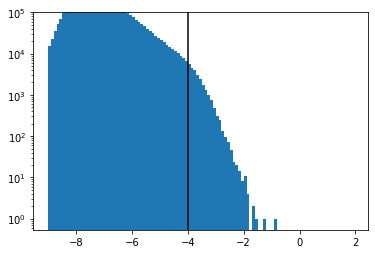

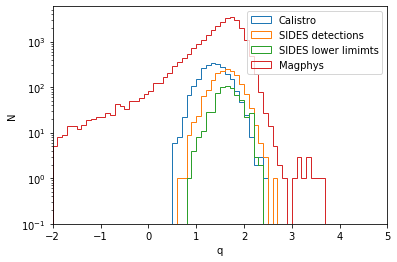

my selection median is:1.7105459191693295
Calistro selection median is:1.40658516501981


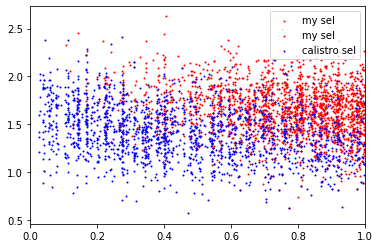

In [113]:
bins = np.arange(-9,2,0.1)
y = np.log10(frad)
plt.hist(y,bins=bins,log=True)
plt.vlines(-4,0,1E5)
plt.ylim(0,1E5)
plt.show()

mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7)
mask_rad_sel = (frad>1E-4)  

bins = np.arange(-2,4,0.1)
mask_calistro = (frad>6E-4)
q_det = q[mask_calistro]
plt.hist(q_det,bins=bins,log=True,histtype='step',label='Calistro'.format())

q_det = q[mask_rad_sel & mask_mass]
plt.hist(q_det,bins=bins,log=True,histtype='step',label='SIDES detections')

frad_lim = 1E-4 / 1E26
lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel & mask_mass]**2 * (1+z[~mask_rad_sel & mask_mass])**(-1-alpha))
q_lim = np.log10(lir[~mask_rad_sel & mask_mass]/3.75E12) - np.log10(lrad_lim)
plt.hist(q_lim,bins=bins,log=True,histtype='step',label='SIDES lower limimts')

#plt.hist(q,bins=bins,histtype='step',label='all q',log=True)
plt.hist(lofar_sed_en1['q_magphys'],bins=bins,histtype='step',label='Magphys',log=True)

plt.xlabel('q')
plt.ylabel('N')
plt.xlim(-2,5)
plt.legend()
plt.show()

x = z[mask_mass & mask_rad_sel]
y = q_det
plt.scatter(x,y,s=1,c='red',label='my sel')

x = z[mask_mass & ~mask_rad_sel]
y = q_lim
plt.scatter(x,y,s=1,c='red',label='my sel')

data = np.append(q_det,q_lim)
mask = ~np.isinf(data)
data = data[mask]
det = np.append(np.ones(len(q_det)),np.zeros(len(q_lim)))[mask]
data_z = np.append(z[mask_mass & mask_rad_sel],z[mask_mass & ~mask_rad_sel])[mask]
kmf = KaplanMeierFitter() 
kmf.fit(data, det,label='Kaplan Meier Estimate')
print('my selection median is:{}'.format(kmf.median_survival_time_))

mask_calistro = (frad>6E-4) & (bethermin_table['REDSHIFT']<1.0)
x = z[mask_calistro]
y = q[mask_calistro]
print('Calistro selection median is:{}'.format(np.median(y)))
plt.scatter(x,y,s=1,c='blue',label='calistro sel')

plt.xlim(0,1)
plt.legend()
plt.show()


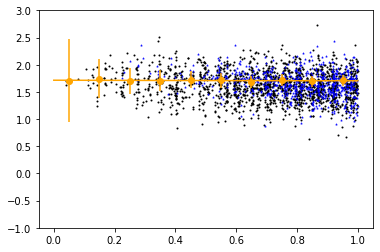

In [118]:
bins_z = np.arange(0,1,0.1)
test = np.digitize(data_z,bins=bins_z)
nums_z,counts = np.unique(test,return_counts=True)

median_q = []
median_q_err = []
for n,num in enumerate(nums_z):
    mask_z = test == num
    data_tmp = data[mask_z]
    det_tmp = det[mask_z]
    if len(data_tmp)==0:
        median_q.append(np.nan)
        continue
    kmf = KaplanMeierFitter() 
    kmf.fit(data_tmp, det_tmp,label='Kaplan Meier Estimate')
    
    x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
    x = np.arange(-1,3,0.01)
    
    lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
    lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
    upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
    upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)
    
    err = upx-lowx
    
    median_q.append(kmf.median_survival_time_)
    median_q_err.append(err)

x = z[mask_mass & mask_rad_sel]
y = q_det
plt.scatter(x,y,s=1,c='black',label='detections')

x = z[mask_mass & ~mask_rad_sel]
y = q_lim
plt.scatter(x,y,s=1,c='blue',label='limits',marker='^')
    
x = bins_z+0.05
y = median_q
plt.scatter(x,y,c='orange')
x = bins_z+0.05
y = median_q
yerr = median_q_err
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')



po = [2,-0.2]
popt,pcov = curve_fit(power_law,x,y,po,sigma=median_q_err)
x = np.arange(0,1,0.001)
y = power_law(x,popt[0],popt[1])
plt.plot(x,y,c='orange')

plt.ylim(-1,3)
plt.show()


## Look at what would be observed if there is a redshift evolution in q

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


-0.5
-0.4
-0.30000000000000004
-0.20000000000000007
-0.10000000000000009


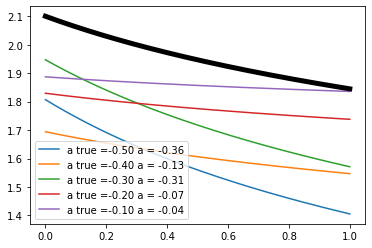

In [86]:
z = bethermin_table['REDSHIFT']
lir = bethermin_table['SFR'] / 1E-10 * 3.8E26
dist = cosmo.luminosity_distance(z).to(u.m).value

params = np.arange(-0.5,0,0.1)
for n,param in enumerate(params):
    print(param)
    N = 2
    q = generate_q_z_evo(len(lir),0.4,z,N,param,dist_type='lognorm')
    lrad = 10**(np.log10(lir/3.75E12) - q)

    alpha = -0.73
    frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-alpha)) * 1E26 #get radio fluxes in Jy

    mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7)
    mask_rad_sel = (frad>1E-4)  

    q_det = q[mask_rad_sel & mask_mass]

    frad_lim = 1E-4 / 1E26
    lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel & mask_mass]**2 * (1+z[~mask_rad_sel & mask_mass])**(-1-alpha))
    q_lim = np.log10(lir[~mask_rad_sel & mask_mass]/3.75E12) - np.log10(lrad_lim)

    data = np.append(q_det,q_lim)
    mask = ~np.isinf(data)
    data = data[mask]
    det = np.append(np.ones(len(q_det)),np.zeros(len(q_lim)))[mask]
    data_z = np.append(z[mask_mass & mask_rad_sel],z[mask_mass & ~mask_rad_sel])[mask]
    kmf = KaplanMeierFitter() 
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    bins_z = np.arange(0,1,0.1)
    test = np.digitize(data_z,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    median_q = []
    for n,num in enumerate(nums_z):
        mask_z = test == num
        data_tmp = data[mask_z]
        det_tmp = det[mask_z]
        if len(data_tmp)==0:
            median_q.append(np.nan)
            continue
        kmf = KaplanMeierFitter() 
        kmf.fit(data_tmp, det_tmp,label='Kaplan Meier Estimate')
        
    
    x = bins_z+0.05
    y = median_q
    po = [2,-0.2]
    popt,pcov = curve_fit(power_law,x,y,po)
    x = np.arange(0,1,0.001)
    y = power_law(x,popt[0],popt[1])
    plt.plot(x,y,label=f'a true ={param:2.2f} a = {popt[1]:2.2f}')

#plot my fit the data on top of the estimates
x = np.arange(0,1,0.001)
y = power_law(x,2.1,-0.187)
plt.plot(x,y,c='black',linewidth=5)
plt.legend()
plt.show()





In [34]:
z = bethermin_table['REDSHIFT']
dist = cosmo.luminosity_distance(z).to(u.m).value

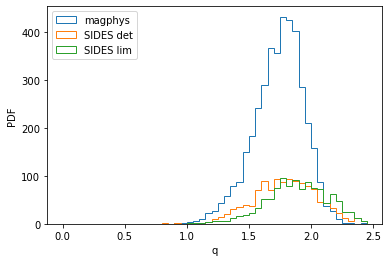

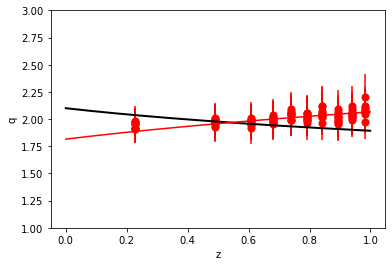

1.816 +/- 0.0948
0.187 +/- 0.0953


In [141]:
z = bethermin_table['REDSHIFT']
lir = bethermin_table['SFR'] / 1E-10 * 3.8E26
dist = cosmo.luminosity_distance(z).to(u.m).value


params = np.arange(-0.5,0,0.1)
median_q_z = []
measured_N = []
measured_a = []
for m,param in enumerate(np.arange(0,10,1)):
    N = 2.1
    alpha=-0.15
    mass_generate = np.log10(bethermin_table['MSTAR']) - 10.2
    q = generate_q_z_evo(len(lir),0.3,mass_generate,N,alpha,dist_type='norm')
    lrad = 10**(np.log10(lir/3.75E12) - q)

    spectral_index = -0.73
    frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-spectral_index)) * 1E26 #get radio fluxes in Jy
    
    ssfr = bethermin_table['SFR']/bethermin_table['MSTAR']
    mask_ssfr = create_ssfr_mask(bethermin_table['REDSHIFT'],ssfr)
    mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7) & mask_ssfr
    mask_rad_sel = (frad>1E-4)  

    q_det = q[mask_rad_sel & mask_mass]

    frad_lim = 1E-4 / 1E26
    lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel & mask_mass]**2 * (1+z[~mask_rad_sel & mask_mass])**(-1-alpha))
    q_lim = np.log10(lir[~mask_rad_sel & mask_mass]/3.75E12) - np.log10(lrad_lim)
    
    if m==0:
        y = detected_sample_en1['q_magphys']#+2.7
        bins=np.arange(0,2.5,0.05)
        plt.hist(y,bins=bins,histtype='step',label='magphys')

        y = q_det
        plt.hist(y,bins=bins,histtype='step',label='SIDES det')

        y = q_lim
        plt.hist(y,bins=bins,histtype='step',label='SIDES lim')

        plt.xlabel('q')
        plt.ylabel('PDF')
        plt.legend(loc='upper left')
        plt.show()

    data = np.append(q_det,q_lim)
    mask = ~np.isinf(data)
    data = data[mask]
    det = np.append(np.ones(len(q_det)),np.zeros(len(q_lim)))[mask]
    #print('there are {} sources with z<0.1'.format(np.sum(z<0.1)))
    #print('there are {} sources with z<0.1 and are detected in the radio '.format(np.sum(z[mask_mass & mask_rad_sel]<0.1)))
    data_z = np.append(z[mask_mass & mask_rad_sel],z[mask_mass & ~mask_rad_sel])[mask]
    kmf = KaplanMeierFitter() 
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    #bins_z = np.arange(0,1,0.1)
    bins_z = []
    percentiles = np.linspace(0,100,11)
    for n,percent in enumerate(percentiles):
        bins_z.append(np.percentile(data_z,percent))
    bins_z = np.array(bins_z)
    
    test = np.digitize(data_z,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    median_q = []
    median_q_err = []
    for n,num in enumerate(nums_z):
        mask_z = test == num
        data_tmp = data[mask_z]
        det_tmp = det[mask_z]
        if len(data_tmp)==0:
            median_q.append(np.nan)
            continue
        kmf = KaplanMeierFitter() 
        kmf.fit(data_tmp, det_tmp,label='Kaplan Meier Estimate')
        

        
        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        median_q.append(kmf.median_survival_time_)
        median_q_err.append(err)
    
    x = get_center(bins_z)
    y = np.array(median_q)[:-1]
    y_err = np.array(median_q_err)[:-1]
    mask = (~np.isnan(y)) & (~np.isinf(y))
    x = x[mask]
    y = y[mask]
    y_err = y_err[mask]
    plt.scatter(x,y,c='red',s=50)
    plt.errorbar(x,y,y_err,c='red',linestyle='')
    po = [1.7,-0.2]
    popt,pcov = curve_fit(power_law,x[2:],y[2:],po,sigma=y_err[2:])
    x = np.arange(0,1,0.001)
    y = power_law(x,popt[0],popt[1])
    #plt.plot(x,y,c='red',alpha=1)
    #print('values: {}'.format(popt))
    #print('errors: {}'.format(pcov))
    #print('---------------------------------')
    measured_N.append(popt[0])
    measured_a.append(popt[1])
    median_q_z.append(median_q)

#plot my fit the data on top of the estimates
x = np.arange(0,1,0.001)
y = power_law(x,N,alpha)
plt.plot(x,y,c='black',linewidth=2)

x = np.arange(0,1,0.001)
y = power_law(x,np.mean(measured_N),np.mean(measured_a))
plt.plot(x,y,c='red',label='fit')

plt.xlabel('z')
plt.ylabel('q')
plt.ylim(1,3)
plt.show()

print(f'{np.mean(measured_N):2.3f} +/- {np.std(measured_N):2.4f}')
print(f'{np.mean(measured_a):2.3f} +/- {np.std(measured_a):2.4f}')





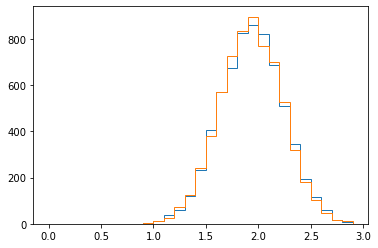

In [120]:

mass_generate = np.log10(bethermin_table['MSTAR']) - 10.2
N = 2.1
alpha = -0.15

q = generate_q_z_evo(len(mass_generate),0.3,mass_generate,N,alpha,dist_type='norm')

plt.hist(q[mask_mass],bins=np.arange(0,3,0.1),histtype='step')


N = 2.1
alpha=-0.15
mass_generate = np.log10(bethermin_table['MSTAR']) - 10.2
q = generate_q_z_evo(len(mass_generate),0.3,mass_generate,N,alpha,dist_type='norm')
plt.hist(q[mask_mass],bins=np.arange(0,3,0.1),histtype='step')
plt.show()

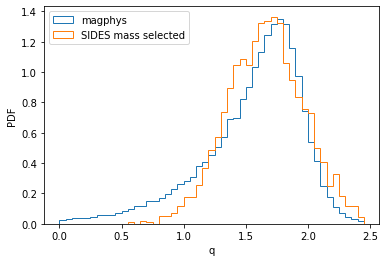

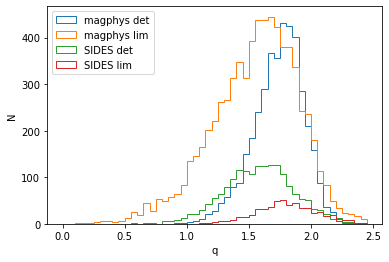

1746
534
[0.040151  0.4218818 0.5681218 0.6515767 0.7118122 0.772412  0.815317
 0.8701726 0.9177108 0.9618321 0.999365 ]
power law fit parameters: alpha = 0.021729 +\- 0.051742, N = 1.6662 +\- 0.047678


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:200: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


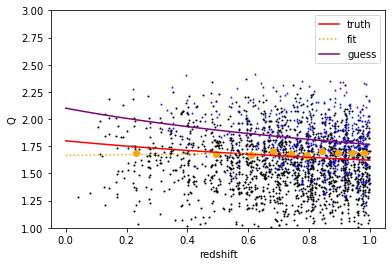

In [230]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 
mask = np.log10(bethermin_table['MSTAR'])>10.2
mass_generate = np.log10(bethermin_table['MSTAR']) - 10.2
N = 1.8
alpha = -0.15

q = generate_q_z_evo(len(mass_generate),0.3,mass_generate,N,alpha,dist_type='norm')

mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7) & mask_ssfr
z = bethermin_table['REDSHIFT'][mask_mass]
lir = bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26
q = q[mask_mass]

lrad = 10**(np.log10(lir/3.75E12) - q)

y = lofar_sed_en1['q_magphys']#+2.7
bins=np.arange(0,2.5,0.05)
plt.hist(y,bins=bins,histtype='step',density=True,label='magphys')

y = q
plt.hist(y,bins=bins,histtype='step',density=True,label='SIDES mass selected')

plt.xlabel('q')
plt.ylabel('PDF')
plt.legend(loc='upper left')
plt.show()




dist = cosmo.luminosity_distance(z).to(u.m).value

spectral_index = -0.73
frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-spectral_index)) * 1E26 #get radio fluxes in Jy

mask_rad_sel = (frad>1E-4)  

q_det_orig = q[mask_rad_sel]
mask = ~np.isinf(q_det_orig)
q_det = q_det_orig[mask]



frad_lim = 1E-4 / 1E26
lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel]**2 * (1+z[~mask_rad_sel])**(-1-alpha))
q_lim_orig = np.log10(lir[~mask_rad_sel]/3.75E12) - np.log10(lrad_lim)
mask = ~np.isinf(q_lim_orig)
q_lim = q_lim_orig[mask]


bins=np.arange(0,2.5,0.05)
y = detected_sample_en1['q_magphys']
plt.hist(y,bins=bins,histtype='step',label='magphys det')
y = limit_sample_en1['q_lim']
plt.hist(y,bins=bins,histtype='step',label='magphys lim')

y = q_det
plt.hist(y,bins=bins,histtype='step',label='SIDES det')

y = q_lim
plt.hist(y,bins=bins,histtype='step',label='SIDES lim')

plt.xlabel('q')
plt.ylabel('N')
plt.legend(loc='upper left')
plt.show()



mask = ~np.isinf(q_det_orig)
x = z[mask_rad_sel][mask]
y = q_det
print(len(y))
plt.scatter(x,y,s=1,c='black')

mask = ~np.isinf(q_lim_orig)
x = z[~mask_rad_sel][mask]
y = q_lim
print(len(y))
plt.scatter(x,y,s=1,marker='^',c='blue')


x = np.arange(0,1,0.001)
y = power_law(x,N,alpha)
plt.plot(x,y,c='red',label='truth')




redshifts = bethermin_table['REDSHIFT'][mask_mass]
bins_z = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
print(bins_z)


num = 10
N = int(len(q_det)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
N = int(len(q_lim)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts =[]
pcovs = []
for n in range(num):
    data = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append( np.ones(len(q_det[bootstrap_det[n]])), np.zeros(len(q_lim[bootstrap_lim[n]])) )
    
    redshift_det = z[mask_rad_sel][bootstrap_det[n]]
    
    redshift_lim = z[~mask_rad_sel][bootstrap_lim[n]]


    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    median_q.append(kmf.median_survival_time_)
    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        values_z = data[mask]
        detections_z = det[mask]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(values_z, detections_z,label='Kaplan Meier Estimate')
        
        ''' if n==5:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()
            print(np.sum(detections_z),len(detections_z))
            ax1.hist(values_z[detections_z.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(values_z[~detections_z.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()'''

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_)
        median_q_err.append(err)
        
    x = get_center(bins_z)
    y = mean_q_agnfitter   
    #print(x,y)
    popt,pcov = curve_fit(power_law,x,y,po,sigma=median_q_err)
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange')
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,1,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = power_law(x,N_mean,alpha_mean)
plt.plot(x,y,c='orange',linestyle='dotted',label='fit')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')

x = np.arange(0,1,0.001)
y = power_law(x,2.1,-0.25)
plt.plot(x,y,c='purple',label='guess')
    
plt.ylim(1,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()

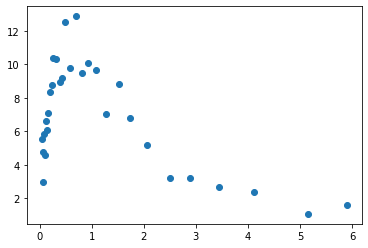

In [41]:
#look at how median q measured iwth survival analysis is biased depending on ratio of limits to detections

ssfr = np.log10(bethermin_table['SFR']/bethermin_table['MSTAR'])
mask_ssfr = create_ssfr_mask(bethermin_table['REDSHIFT'],ssfr)
mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.45) & mask_ssfr
mass_generate = np.log10(bethermin_table['MSTAR'][mask_mass]) - 10.2
z = bethermin_table['REDSHIFT'][mask_mass]
dist = cosmo.luminosity_distance(z).to(u.m).value
mstar = np.log10(bethermin_table['MSTAR'][mask_mass])
lir = bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26

x = []
y = []
for N in np.arange(1.5,3.0,0.05):


    alpha = -0.15
    #q = generate_q_z_evo(len(bethermin_table[mask_mass]),0.3,mass_generate,N,alpha,dist_type='norm')
    q = generate_q_z_evo(len(lir),0.3,mass_generate,N,alpha,dist_type='norm')
    lrad = 10**(np.log10(lir/3.75E12) - q)

    dist = cosmo.luminosity_distance(z).to(u.m).value

    spectral_index = -0.73
    frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-spectral_index)) * 1E26 #get radio fluxes in Jy

    mask_rad_sel = (frad>1E-4)  

    q_det_orig = q[mask_rad_sel]
    mask = ~np.isinf(q_det_orig)
    q_det = q_det_orig[mask]

    frad_lim = 1E-4 / 1E26
    lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel]**2 * (1+z[~mask_rad_sel])**(-1-alpha))
    q_lim_orig = np.log10(lir[~mask_rad_sel]/3.75E12) - np.log10(lrad_lim)
    mask = ~np.isinf(q_lim_orig)
    q_lim = q_lim_orig[mask]
    
    num = 100
    N = int(len(q_det)*0.9)
    bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
    N = int(len(q_lim)*0.9)
    bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)

    medians = np.array([])
    for n in range(num):
        data = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
        det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

        kmf =KaplanMeierFitter()
        kmf.fit(data,det)

        medians = np.append(medians,kmf.median_survival_time_)
        #x_kmf = kmf.cumulative_density_['KM_estimate'].index

        #lowx_kmf = kmf.confidence_interval_cumulative_density_['KM_estimate_lower_0.95']
        #lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        #upx_kmf = kmf.confidence_interval_cumulative_density_['KM_estimate_upper_0.95']
        #upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        #err = lowx-upx
    err = np.std(medians)
    median = np.mean(medians)
    x.append(len(q_det)/len(q_lim))
    y.append((median - np.median(q))/err)
    
plt.scatter(x,y)
plt.show()

In [44]:
median - np.median(q)

0.13096755766494628

In [47]:
x_kmf = kmf.cumulative_density_['KM_estimate'].index

lowx_kmf = kmf.confidence_interval_cumulative_density_['KM_estimate_lower_0.95']
lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
upx_kmf = kmf.confidence_interval_cumulative_density_['KM_estimate_upper_0.95']
upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

err = lowx-upx
err

0.16689162762365117

In [46]:
np.std(medians)

0.023572675398201515

[0.038581  0.4022449 0.5462192 0.6279629 0.7017626 0.7614415 0.8118026
 0.8662166 0.9155028 0.9604207 0.999911 ]


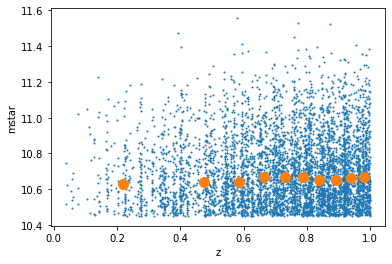

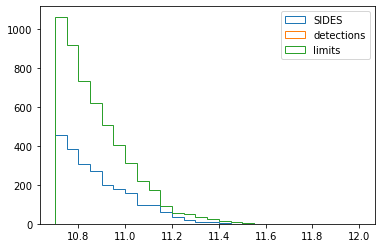

[0.038581  0.4022449 0.5462192 0.6279629 0.7017626 0.7614415 0.8118026
 0.8662166 0.9155028 0.9604207 0.999911 ]
power law fit parameters: m = 0.058432 +\- 0.027805, c = 1.6741 +\- 0.019847
[ 1.69086391 -0.00378121]


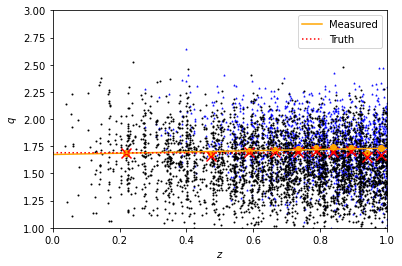

In [64]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

ssfr = np.log10(bethermin_table['SFR']/bethermin_table['MSTAR'])
mask_ssfr = create_ssfr_mask(bethermin_table['REDSHIFT'],ssfr)
mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.45) & mask_ssfr
mass_generate = np.log10(bethermin_table['MSTAR'][mask_mass]) - 10.2
z = bethermin_table['REDSHIFT'][mask_mass]
dist = cosmo.luminosity_distance(z).to(u.m).value
mstar = np.log10(bethermin_table['MSTAR'][mask_mass])
lir = bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26

N = 1.8
alpha = -0.15
#q = generate_q_z_evo(len(bethermin_table[mask_mass]),0.3,mass_generate,N,alpha,dist_type='norm')
q = generate_q_z_evo(len(lir),0.3,mass_generate,N,alpha,dist_type='norm')
lrad = 10**(np.log10(lir/3.75E12) - q)

dist = cosmo.luminosity_distance(z).to(u.m).value

spectral_index = -0.73
frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-spectral_index)) * 1E26 #get radio fluxes in Jy

flim = 1E-4
mask_rad_sel = (frad>flim)  

q_det_orig = q[mask_rad_sel]
mask = ~np.isinf(q_det_orig)
q_det = q_det_orig[mask]

frad_lim = flim / 1E26
lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel]**2 * (1+z[~mask_rad_sel])**(-1-alpha))
q_lim_orig = np.log10(lir[~mask_rad_sel]/3.75E12) - np.log10(lrad_lim)
mask = ~np.isinf(q_lim_orig)
q_lim = q_lim_orig[mask]


x = z
y = mstar
plt.scatter(x,y,s=1)

redshifts = z
bins_z = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
print(bins_z)
x = get_center(bins_z)
y,_,_ = scipy.stats.binned_statistic(z,mstar,'median',bins=bins_z)
plt.scatter(x,y,s=100)
plt.xlabel('z')
plt.ylabel('mstar')
plt.show()








bins = np.arange(10.7,12,0.05)
y = mstar
plt.hist(y,bins=bins,histtype='step',label='SIDES')
y = detected_sample_en1['Mass_median']
plt.hist(y,bins=bins,histtype='step',label='detections')
y = limit_sample_en1['Mass_median']
plt.hist(y,bins=bins,histtype='step',label='limits')
plt.legend()
plt.show()

mask_det = det.astype(bool)
x = z[~mask_rad_sel]
y = q_lim
plt.scatter(x,y,s=1,marker='^',c='blue')

x = z[mask_rad_sel]
y = q_det
plt.scatter(x,y,s=1,c='black',)




redshifts = z
bins_z = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
print(bins_z)


num = 100
N = int(len(q_det)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
N = int(len(q_lim)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
    #data = q_det[bootstrap_det[n]]
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    #det = np.ones(len(bootstrap_det[n]))
    
    redshift_det = z[mask_rad_sel][bootstrap_det[n]]
    ldust_det = lir[mask_rad_sel][bootstrap_det[n]]
    
    redshift_lim = z[~mask_rad_sel][bootstrap_lim[n]]
    ldust_lim = lir[~mask_rad_sel][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    #redshifts = redshift_det
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_dets = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_dets,label='Kaplan Meier Estimate')
        


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = lowx-upx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = np.array(get_center(bins_z))
    y = np.array(mean_q_agnfitter)
    sigma = np.array(median_q_err)
    mask = (~np.isnan(y)) & (~np.isinf(y)) & (sigma>0)
    popt,pcov = curve_fit(linear_fit,x[mask],y[mask],sigma=sigma[mask])
    #popt,pcov = curve_fit(power_law,x,y,sigma=median_q_err)
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.nanmean(median_q,axis=0)
errs = np.nanstd(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange')
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

'''#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,1,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = linear_fit(x,N_mean,alpha_mean)
plt.plot(x,y,c='orange')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')
'''


x = np.arange(0,1,0.001)
m_mean = np.nanmean(popts[:,0])
m_std = np.nanstd(popts[:,0])
c_mean = np.nanmean(popts[:,1])
c_std = np.nanstd(popts[:,1])
y = linear_fit(x,m_mean,c_mean)
plt.plot(x,y,c='orange',label='Measured')

print(f'power law fit parameters: m = {m_mean:2.5} +\- {m_std:2.5}, c = {c_mean:2.5} +\- {c_std:2.5}')



x = get_center(bins_z)
y,_,_ = scipy.stats.binned_statistic(z,q,'median',bins=bins_z)
popt,pcov = curve_fit(power_law,x,y)
plt.scatter(x,y,s=100,c='red',marker='x')
x = np.arange(0,1,0.001)
y = power_law(x,popt[0],popt[1])
plt.plot(x,y,c='red',linestyle='dotted',label='Truth')
print(popt)




plt.xlim(0,1)
plt.ylim(1,3)
plt.xlabel('$z$')
plt.ylabel('$q$')
plt.legend()
plt.savefig('../figures/plots/SIDES_q_z_evo.pdf',format='pdf')
plt.show()

ratio of det/lim is: 0.5599886007409518
[0.038581  0.4022449 0.5462192 0.6279629 0.7017626 0.7614415 0.8118026
 0.8662166 0.9155028 0.9604207 0.999911 ]
power law fit parameters: m = 0.22288 +\- 0.043788, c = 1.6327 +\- 0.026326
[1.6689606  0.02571082]


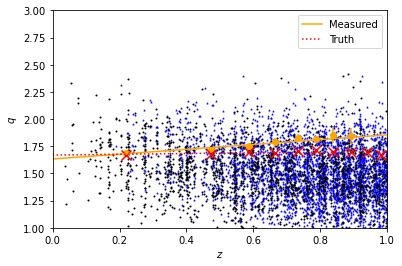

In [72]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

ssfr = np.log10(bethermin_table['SFR']/bethermin_table['MSTAR'])
mask_ssfr = create_ssfr_mask(bethermin_table['REDSHIFT'],ssfr)
mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.45) & mask_ssfr
mass_generate = np.log10(bethermin_table['MSTAR'][mask_mass]) - 10.2
z = bethermin_table['REDSHIFT'][mask_mass]
dist = cosmo.luminosity_distance(z).to(u.m).value
mstar = np.log10(bethermin_table['MSTAR'][mask_mass])
lir = bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26

N = 1.8
alpha = -0.15
#q = generate_q_z_evo(len(bethermin_table[mask_mass]),0.3,mass_generate,N,alpha,dist_type='norm')
q = generate_q_z_evo(len(lir),0.3,mass_generate,N,alpha,dist_type='norm')
lrad = 10**(np.log10(lir/3.75E12) - q)

dist = cosmo.luminosity_distance(z).to(u.m).value

spectral_index = -0.73
frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-spectral_index)) * 1E26 #get radio fluxes in Jy

flim = 2.5E-4
mask_rad_sel = (frad>flim)  

print('ratio of det/lim is: {}'.format(np.sum(mask_rad_sel)/np.sum(~mask_rad_sel)))

q_det_orig = q[mask_rad_sel]
mask = ~np.isinf(q_det_orig)
q_det = q_det_orig[mask]

frad_lim = flim / 1E26
lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel]**2 * (1+z[~mask_rad_sel])**(-1-alpha))
q_lim_orig = np.log10(lir[~mask_rad_sel]/3.75E12) - np.log10(lrad_lim)
mask = ~np.isinf(q_lim_orig)
q_lim = q_lim_orig[mask]




mask_det = det.astype(bool)
x = z[~mask_rad_sel]
y = q_lim
plt.scatter(x,y,s=1,marker='^',c='blue')

x = z[mask_rad_sel]
y = q_det
plt.scatter(x,y,s=1,c='black',)




redshifts = z
bins_z = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
print(bins_z)


num = 100
N = int(len(q_det)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
N = int(len(q_lim)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
    #data = q_det[bootstrap_det[n]]
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    #det = np.ones(len(bootstrap_det[n]))
    
    redshift_det = z[mask_rad_sel][bootstrap_det[n]]
    ldust_det = lir[mask_rad_sel][bootstrap_det[n]]
    
    redshift_lim = z[~mask_rad_sel][bootstrap_lim[n]]
    ldust_lim = lir[~mask_rad_sel][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    #redshifts = redshift_det
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_dets = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_dets,label='Kaplan Meier Estimate')
        


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = lowx-upx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)
        
    x = np.array(get_center(bins_z))
    y = np.array(mean_q_agnfitter)
    sigma = np.array(median_q_err)
    mask = (~np.isnan(y)) & (~np.isinf(y)) & (sigma>0)
    popt,pcov = curve_fit(linear_fit,x[mask],y[mask],sigma=sigma[mask])
    #popt,pcov = curve_fit(power_law,x,y,sigma=median_q_err)
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.nanmean(median_q,axis=0)
errs = np.nanstd(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange')
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

'''#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,1,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = linear_fit(x,N_mean,alpha_mean)
plt.plot(x,y,c='orange')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')
'''


x = np.arange(0,1,0.001)
m_mean = np.nanmean(popts[:,0])
m_std = np.nanstd(popts[:,0])
c_mean = np.nanmean(popts[:,1])
c_std = np.nanstd(popts[:,1])
y = linear_fit(x,m_mean,c_mean)
plt.plot(x,y,c='orange',label='Measured')

print(f'power law fit parameters: m = {m_mean:2.5} +\- {m_std:2.5}, c = {c_mean:2.5} +\- {c_std:2.5}')



x = get_center(bins_z)
y,_,_ = scipy.stats.binned_statistic(z,q,'median',bins=bins_z)
popt,pcov = curve_fit(power_law,x,y)
plt.scatter(x,y,s=100,c='red',marker='x')
x = np.arange(0,1,0.001)
y = power_law(x,popt[0],popt[1])
plt.plot(x,y,c='red',linestyle='dotted',label='Truth')
print(popt)




plt.xlim(0,1)
plt.ylim(1,3)
plt.xlabel('$z$')
plt.ylabel('$q$')
plt.legend()
plt.savefig('../figures/plots/SIDES_q_z_evo_bias.pdf',format='pdf')
plt.show()

In [49]:
np.mean(median_q,axis=0)

array([2.37002219, 2.42749658,        inf,        inf, 2.57135157,
              inf,        inf,        inf,        inf,        inf])

ratio of det/lim is: 6.208121827411167
[10.04918867 10.09978513 10.15238196 10.20848724 10.27297746 10.33952257
 10.42022297 10.50069256 10.60276204 10.7563487  11.47205176]
1223
(100, 1100)
power law fit parameters: alpha = -0.12931 +\- 0.044096, N = 1.7936 +\- 0.024556
[ 1.78540419 -0.11402382]


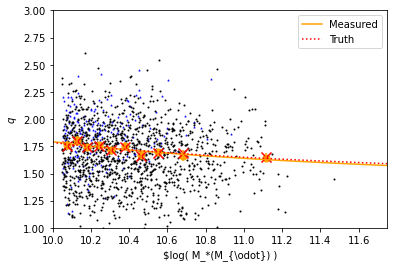

In [73]:
#Now look at redshift evolution scatter with bootstraping
ssfr = np.log10(bethermin_table['SFR']/bethermin_table['MSTAR'])
mask_ssfr = create_ssfr_mask(bethermin_table['REDSHIFT'],ssfr)
mask_mass = (bethermin_table['REDSHIFT']<0.4) & (np.log10(bethermin_table['MSTAR'])>10.05) & mask_ssfr
mass_generate = np.log10(bethermin_table['MSTAR'][mask_mass]) - 10.0
z = bethermin_table['REDSHIFT'][mask_mass]
mstar = np.log10(bethermin_table['MSTAR'][mask_mass])
lir = bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26

N = 1.8#2.1
alpha = -0.15
#q = generate_q_z_evo(len(bethermin_table[mask_mass]),0.3,mass_generate,N,alpha,dist_type='norm')
q = generate_q_z_evo(len(lir),0.3,mass_generate,N,alpha,dist_type='norm')
lrad = 10**(np.log10(lir/3.75E12) - q)

dist = cosmo.luminosity_distance(z).to(u.m).value

spectral_index = -0.73
frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-spectral_index)) * 1E26 #get radio fluxes in Jy

flim = 1E-4
mask_rad_sel = (frad>flim)  

print('ratio of det/lim is: {}'.format(np.sum(mask_rad_sel)/np.sum(~mask_rad_sel)))

q_det_orig = q[mask_rad_sel]
mask = ~np.isinf(q_det_orig)
q_det = q_det_orig[mask]

frad_lim = flim / 1E26
lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel]**2 * (1+z[~mask_rad_sel])**(-1-alpha))
q_lim_orig = np.log10(lir[~mask_rad_sel]/3.75E12) - np.log10(lrad_lim)
mask = ~np.isinf(q_lim_orig)
q_lim = q_lim_orig[mask]



x = mstar[~mask_rad_sel]
y = q_lim
plt.scatter(x,y,s=1,marker='^',c='blue')

x = mstar[mask_rad_sel]
y = q_det
plt.scatter(x,y,s=1,c='black')




redshifts = mstar
bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
bins_z[0] = bins_z[0] - 0.001
bins_z[-1] = bins_z[-1] + 0.001
print(bins_z)


num = 100
N = int(len(q_det)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
N = int(len(q_lim)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)
print(len(q_det))
print(bootstrap_det.shape)
median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = mstar[mask_rad_sel][bootstrap_det[n]]
    ldust_det = lir[mask_rad_sel][bootstrap_det[n]]
    
    redshift_lim = mstar[~mask_rad_sel][bootstrap_lim[n]]
    ldust_lim = lir[~mask_rad_sel][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_dets = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_dets,label='Kaplan Meier Estimate')
        


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr = np.array(median_q_err)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(power_law,x[mask]-10.0,y[mask],sigma=yerr[mask])
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange',s=50)
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,2,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = power_law(x,N_mean,alpha_mean)
plt.plot(x+10.0,y,c='orange',label='Measured')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')
 
x = get_center(bins_z)
y,_,_ = scipy.stats.binned_statistic(mstar,q,'median',bins=bins_z)
popt,pcov = curve_fit(power_law,x-10.0,y)
plt.scatter(x,y,s=100,c='red',marker='x')
x = np.arange(0,2,0.001)
y = power_law(x,popt[0],popt[1])
plt.plot(x+10.0,y,c='red',linestyle='dotted',label='Truth')
print(popt)

plt.xlim(10.0,11.75)
plt.ylim(1,3)
plt.xlabel('$log( M_*(M_{\odot}) )')
plt.ylabel('$q$')
plt.legend()
plt.savefig('../figures/plots/SIDES_mstar_evo.pdf',format='pdf')
plt.show()

ratio of det/lim is: 0.6009019165727171
[10.04918867 10.09978513 10.15238196 10.20848724 10.27297746 10.33952257
 10.42022297 10.50069256 10.60276204 10.7563487  11.47205176]
533
(100, 479)


/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


power law fit parameters: alpha = -0.021646 +\- 0.38009, N = 1.7581 +\- 0.28179
[ 1.82361149 -0.15142285]


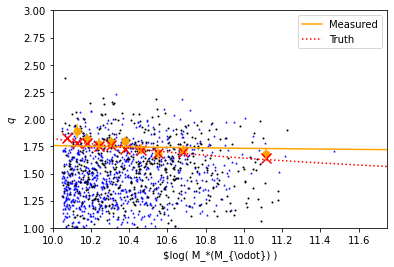

In [74]:
#Now look at redshift evolution scatter with bootstraping
ssfr = np.log10(bethermin_table['SFR']/bethermin_table['MSTAR'])
mask_ssfr = create_ssfr_mask(bethermin_table['REDSHIFT'],ssfr)
mask_mass = (bethermin_table['REDSHIFT']<0.4) & (np.log10(bethermin_table['MSTAR'])>10.05) & mask_ssfr
mass_generate = np.log10(bethermin_table['MSTAR'][mask_mass]) - 10.0
z = bethermin_table['REDSHIFT'][mask_mass]
mstar = np.log10(bethermin_table['MSTAR'][mask_mass])
lir = bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26

N = 1.8#2.1
alpha = -0.15
#q = generate_q_z_evo(len(bethermin_table[mask_mass]),0.3,mass_generate,N,alpha,dist_type='norm')
q = generate_q_z_evo(len(lir),0.3,mass_generate,N,alpha,dist_type='norm')
lrad = 10**(np.log10(lir/3.75E12) - q)

dist = cosmo.luminosity_distance(z).to(u.m).value

spectral_index = -0.73
frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-spectral_index)) * 1E26 #get radio fluxes in Jy

flim = 5E-4
mask_rad_sel = (frad>flim)  

print('ratio of det/lim is: {}'.format(np.sum(mask_rad_sel)/np.sum(~mask_rad_sel)))

q_det_orig = q[mask_rad_sel]
mask = ~np.isinf(q_det_orig)
q_det = q_det_orig[mask]

frad_lim = flim / 1E26
lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel]**2 * (1+z[~mask_rad_sel])**(-1-alpha))
q_lim_orig = np.log10(lir[~mask_rad_sel]/3.75E12) - np.log10(lrad_lim)
mask = ~np.isinf(q_lim_orig)
q_lim = q_lim_orig[mask]



x = mstar[~mask_rad_sel]
y = q_lim
plt.scatter(x,y,s=1,marker='^',c='blue')

x = mstar[mask_rad_sel]
y = q_det
plt.scatter(x,y,s=1,c='black')




redshifts = mstar
bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
bins_z[0] = bins_z[0] - 0.001
bins_z[-1] = bins_z[-1] + 0.001
print(bins_z)


num = 100
N = int(len(q_det)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
N = int(len(q_lim)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)
print(len(q_det))
print(bootstrap_det.shape)
median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = mstar[mask_rad_sel][bootstrap_det[n]]
    ldust_det = lir[mask_rad_sel][bootstrap_det[n]]
    
    redshift_lim = mstar[~mask_rad_sel][bootstrap_lim[n]]
    ldust_lim = lir[~mask_rad_sel][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_dets = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_dets,label='Kaplan Meier Estimate')
        


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_survival_time_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr = np.array(median_q_err)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(power_law,x[mask]-10.0,y[mask],sigma=yerr[mask])
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange',s=50)
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,2,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = power_law(x,N_mean,alpha_mean)
plt.plot(x+10.0,y,c='orange',label='Measured')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')
 
x = get_center(bins_z)
y,_,_ = scipy.stats.binned_statistic(mstar,q,'median',bins=bins_z)
popt,pcov = curve_fit(power_law,x-10.0,y)
plt.scatter(x,y,s=100,c='red',marker='x')
x = np.arange(0,2,0.001)
y = power_law(x,popt[0],popt[1])
plt.plot(x+10.0,y,c='red',linestyle='dotted',label='Truth')
print(popt)

plt.xlim(10.0,11.75)
plt.ylim(1,3)
plt.xlabel('$log( M_*(M_{\odot}) )')
plt.ylabel('$q$')
plt.legend()
plt.savefig('../figures/plots/SIDES_mstar_evo_bias.pdf',format='pdf')
plt.show()

ratio of det/lim is: 36.2
ratio of det/lim is: 13.307692307692308
ratio of det/lim is: 7.857142857142857
ratio of det/lim is: 7.454545454545454
ratio of det/lim is: 6.153846153846154
ratio of det/lim is: 5.0
ratio of det/lim is: 3.8947368421052633
ratio of det/lim is: 3.5365853658536586
ratio of det/lim is: 3.227272727272727
ratio of det/lim is: 2.509433962264151
ratio of det/lim is: 2.509433962264151
ratio of det/lim is: 2.0491803278688523
ratio of det/lim is: 1.8615384615384616
ratio of det/lim is: 1.6956521739130435
ratio of det/lim is: 1.547945205479452
ratio of det/lim is: 1.5135135135135136
ratio of det/lim is: 1.48
ratio of det/lim is: 1.2682926829268293
ratio of det/lim is: 1.2142857142857142
ratio of det/lim is: 1.1379310344827587
ratio of det/lim is: 1.1136363636363635
ratio of det/lim is: 1.0666666666666667
ratio of det/lim is: 1.0217391304347827
ratio of det/lim is: 0.9578947368421052
ratio of det/lim is: 0.8787878787878788
ratio of det/lim is: 0.8787878787878788
ratio of d

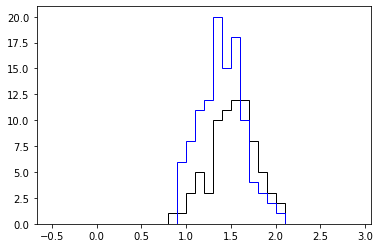

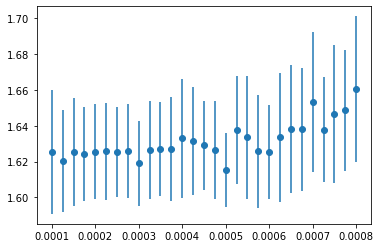

[ 3.22549575 88.39281669  1.62354789]


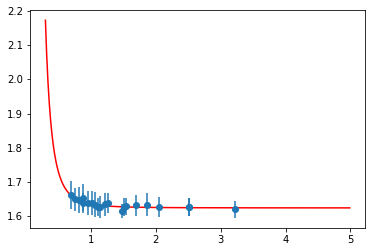

In [85]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 
#Now look at redshift evolution scatter with bootstraping
ssfr = np.log10(bethermin_table['SFR']/bethermin_table['MSTAR'])
mask_ssfr = create_ssfr_mask(bethermin_table['REDSHIFT'],ssfr)
mask_mass = (bethermin_table['REDSHIFT']<0.4) & (np.log10(bethermin_table['MSTAR'])>10.7) & mask_ssfr
mass_generate = np.log10(bethermin_table['MSTAR'][mask_mass]) - 10.0
z = bethermin_table['REDSHIFT'][mask_mass]
mstar = np.log10(bethermin_table['MSTAR'][mask_mass])
lir = bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26

N = 1.8#2.1
alpha = -0.15
#q = generate_q_z_evo(len(bethermin_table[mask_mass]),0.3,mass_generate,N,alpha,dist_type='norm')
q = generate_q_z_evo(len(lir),0.3,mass_generate,N,alpha,dist_type='norm')
lrad = 10**(np.log10(lir/3.75E12) - q)

dist = cosmo.luminosity_distance(z).to(u.m).value

spectral_index = -0.73
frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-spectral_index)) * 1E26 #get radio fluxes in Jy







flims = np.arange(100,801,25)*1E-6
spectral_index = -0.63



medians = []
errs = []
ratio = []
for m,flim in enumerate(flims):
    mask_det = frad>flim

    mask_rad_sel = (frad>flim)  

    print('ratio of det/lim is: {}'.format(np.sum(mask_rad_sel)/np.sum(~mask_rad_sel)))

    q_det_orig = q[mask_rad_sel]
    mask = ~np.isinf(q_det_orig)
    q_det = q_det_orig[mask]

    frad_lim = flim / 1E26
    lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel]**2 * (1+z[~mask_rad_sel])**(-1-alpha))
    q_lim_orig = np.log10(lir[~mask_rad_sel]/3.75E12) - np.log10(lrad_lim)
    mask = ~np.isinf(q_lim_orig)
    q_lim = q_lim_orig[mask]
    
    ratio.append(len(q_det)/len(q_lim))

    
    num = 100
    N = int(len(q_det)*0.9)
    bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
    N = int(len(q_lim)*0.9)
    bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)
    
    median_q = []
    for n in range(num):
        data = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
        #data[flag_detected] = q_lim[flag_detected]
        det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))


        kmf = KaplanMeierFitter() 

        ## Fit the data into the model
        kmf.fit(data, det,label='Kaplan Meier Estimate')

        median_q.append(kmf.median_survival_time_)



    median_q = np.array(median_q)

    medians.append(np.mean(median_q))
    errs.append(np.std(median_q))

    
bins=np.arange(-0.5,3.0,0.1)
y = q_det
plt.hist(y,bins=bins,histtype='step',color='black')
y = q_lim
plt.hist(y,bins=bins,histtype='step',color='blue')
plt.show()

x = flims
y = medians
plt.errorbar(x,y,yerr=errs,linestyle='',marker='o')
plt.show()

mask = np.array(ratio)<3.5
x = np.array(ratio)[mask]
y = np.array(medians)[mask]
plt.errorbar(x,y,yerr=np.array(errs)[mask],linestyle='',marker='o')

popt,pcov = curve_fit(fit_func,x,y,sigma=np.array(errs)[mask],maxfev=10000)
print(popt)
x = np.arange(0.3,5,0.01)
y = fit_func(x,popt[0],popt[1],popt[2])
plt.plot(x,y,c='red')
plt.show()










In [84]:

mass_bins = np.array([ 10.20848724, 10.27297746, 10.33952257,
 10.42022297, 10.50069256, 10.60276204, 10.7563487,  11.47205176])

popts = np.array([])
pcovs = np.array([])
for i in range(len(mass_bins)-1):

    #Now look at redshift evolution scatter with bootstraping
    #Bootstrap the sample and find the median q to see the variation you get 
    #Now look at redshift evolution scatter with bootstraping
    ssfr = np.log10(bethermin_table['SFR']/bethermin_table['MSTAR'])
    mask_ssfr = create_ssfr_mask(bethermin_table['REDSHIFT'],ssfr)
    mask_mass = (bethermin_table['REDSHIFT']<0.4) & (np.log10(bethermin_table['MSTAR'])>mass_bins[i]) & (np.log10(bethermin_table['MSTAR'])<mass_bins[i+1]) & mask_ssfr
    mass_generate = np.log10(bethermin_table['MSTAR'][mask_mass]) - 10.0
    z = bethermin_table['REDSHIFT'][mask_mass]
    mstar = np.log10(bethermin_table['MSTAR'][mask_mass])
    lir = bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26

    N = 1.8#2.1
    alpha = -0.15
    #q = generate_q_z_evo(len(bethermin_table[mask_mass]),0.3,mass_generate,N,alpha,dist_type='norm')
    q = generate_q_z_evo(len(lir),0.3,mass_generate,N,alpha,dist_type='norm')
    lrad = 10**(np.log10(lir/3.75E12) - q)

    dist = cosmo.luminosity_distance(z).to(u.m).value

    spectral_index = -0.73
    frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-spectral_index)) * 1E26 #get radio fluxes in Jy


    flims = np.arange(100,801,25)*1E-6
    spectral_index = -0.63



    medians = []
    errs = []
    ratio = []
    for m,flim in enumerate(flims):
        mask_det = frad>flim

        mask_rad_sel = (frad>flim)  

        #print('ratio of det/lim is: {}'.format(np.sum(mask_rad_sel)/np.sum(~mask_rad_sel)))

        q_det_orig = q[mask_rad_sel]
        mask = ~np.isinf(q_det_orig)
        q_det = q_det_orig[mask]

        frad_lim = flim / 1E26
        lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel]**2 * (1+z[~mask_rad_sel])**(-1-alpha))
        q_lim_orig = np.log10(lir[~mask_rad_sel]/3.75E12) - np.log10(lrad_lim)
        mask = ~np.isinf(q_lim_orig)
        q_lim = q_lim_orig[mask]

        ratio.append(len(q_det)/len(q_lim))


        num = 100
        N = int(len(q_det)*0.9)
        bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
        N = int(len(q_lim)*0.9)
        bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)

        median_q = []
        for n in range(num):
            data = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
            #data[flag_detected] = q_lim[flag_detected]
            det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))


            kmf = KaplanMeierFitter() 

            ## Fit the data into the model
            kmf.fit(data, det,label='Kaplan Meier Estimate')

            median_q.append(kmf.median_survival_time_)



        median_q = np.array(median_q)

        medians.append(np.mean(median_q))
        errs.append(np.std(median_q))

    
    mask = ~np.isinf(medians)
    x = np.array(ratio)[mask]
    y = np.array(medians)[mask]
    sigma = np.array(errs)[mask]
    #plt.errorbar(x,y,yerr=sigma,linestyle='',marker='o')

    popt,pcov = curve_fit(fit_func,x,y,sigma=sigma,maxfev=10000)
    print(popt)
    #x = np.arange(0.25,5,0.01)
    #y = fit_func(x,popt[0],popt[1],popt[2])
    #plt.plot(x,y,c='red')
    #plt.show()

    #print(fit_func(0.3,popt[0],popt[1],popt[2]) - fit_func(5,popt[0],popt[1],popt[2]))
    popts = np.append(popts,popt)
    pcovs = np.append(pcovs,pcov)
    

popts = popts.reshape(len(mass_bins)-1,3)
    
x = get_center(mass_bins)
y = popts[:,0]
plt.scatter(x,y)
plt.show()

x = get_center(mass_bins)
y = popts[:,1]
plt.scatter(x,y)
plt.show()











[ -0.81065125 161.67609957   1.76108645]
[6.81987523e+00 3.16711455e+04 1.65153432e+00]
[  0.25303822 129.11076758   1.70902266]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

In [61]:
len(mstar)

1013

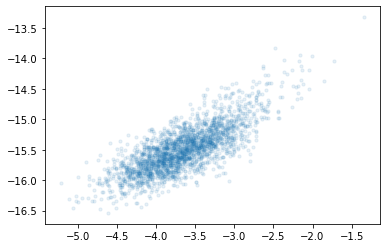

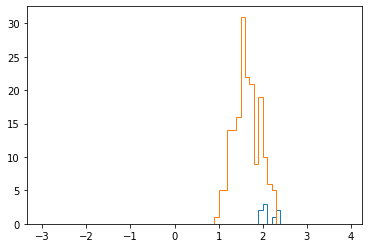

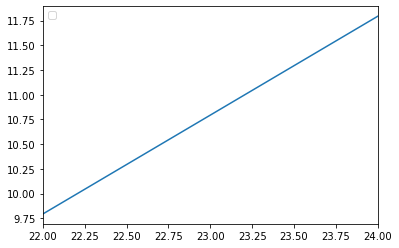

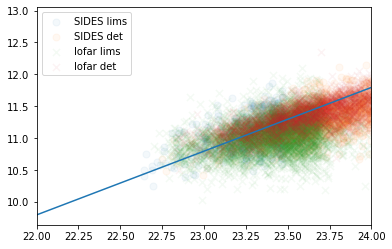

In [280]:
mask = np.log10(bethermin_table['MSTAR'])>10.2
mass_generate = np.log10(bethermin_table['MSTAR']) - 10.2
N = 1.8
alpha = -0.15

q = generate_q_z_evo(len(mass_generate),0.3,mass_generate,N,alpha,dist_type='norm')

mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7) & mask_ssfr
z = bethermin_table['REDSHIFT'][mask_mass]
lir = bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26
q = q[mask_mass]

lrad = 10**(np.log10(lir/3.75E12) - q)




dist = cosmo.luminosity_distance(z).to(u.m).value

spectral_index = -0.73
frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-spectral_index)) * 1E26 #get radio fluxes in Jy

mask_rad_sel = (frad>1E-4)  

q_det_orig = q[mask_rad_sel]
mask = ~np.isinf(q_det_orig)
q_det = q_det_orig[mask]



frad_lim = 1E-4 / 1E26
lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel]**2 * (1+z[~mask_rad_sel])**(-1-alpha))
q_lim_orig = np.log10(lir[~mask_rad_sel]/3.75E12) - np.log10(lrad_lim)
mask = ~np.isinf(q_lim_orig)
q_lim = q_lim_orig[mask]

ldust_flux = np.log10(lir/(4*np.pi*dist**2))

plt.scatter(np.log10(frad),ldust_flux,s=10,alpha=0.1)
plt.show()


bins = np.arange(-3,4,0.1)
mask = z[~mask_rad_sel]<0.4
x = np.log10(lrad_lim[mask])
y = np.log10(lir[~mask_rad_sel][mask])
y = y - x - np.log10(3.75E12)
plt.hist(y,bins=bins,histtype='step')
#plt.scatter(x,y,s=50,alpha=0.2,label='SIDES lims')

mask = z[mask_rad_sel]<0.4
x = np.log10(lrad[mask_rad_sel][mask])
y = np.log10(lir[mask_rad_sel][mask])
#plt.scatter(x,y,s=50,alpha=0.2,label='SIDES det')
y = y - x - np.log10(3.75E12)
plt.hist(y,bins=bins,histtype='step')
plt.show()

mask = limit_sample_en1['Z_BEST']<0.4
x = np.log10(limit_sample_en1['radio_luminosity_limit'][mask])
y = np.log10(limit_sample_en1['Ldust_bayes'][mask])
#plt.scatter(x,y,s=50,alpha=0.2,label='lofar lims',marker='x')

mask = detected_sample_en1['Z_BEST']<0.4
x = np.log10(detected_sample_en1['radio_luminosity'][mask])
y = np.log10(detected_sample_en1['Ldust_bayes'][mask])
#plt.scatter(x,y,s=50,alpha=0.2,label='lofar det',marker='x')

x = np.arange(22,25,1)
y = linear_fit(x,1,1.8 - np.log10(3.8E26) + np.log10(3.75E12))
plt.plot(x,y)
plt.xlim(22,24)
plt.legend()
plt.show()



mask = z[~mask_rad_sel]>0.4
x = np.log10(lrad_lim[mask])
y = np.log10(lir[~mask_rad_sel][mask]/3.8E26)
plt.scatter(x,y,s=50,alpha=0.05,label='SIDES lims')

mask = z[mask_rad_sel]>0.4
x = np.log10(lrad[mask_rad_sel][mask])
y = np.log10(lir[mask_rad_sel][mask]/3.8E26)
plt.scatter(x,y,s=50,alpha=0.05,label='SIDES det')

mask = limit_sample_en1['Z_BEST']>0.4
x = np.log10(limit_sample_en1['radio_luminosity_limit'][mask])
y = np.log10(limit_sample_en1['Ldust_bayes'][mask]/3.8E26)
plt.scatter(x,y,s=50,alpha=0.05,label='lofar lims',marker='x')

mask = detected_sample_en1['Z_BEST']>0.4
x = np.log10(detected_sample_en1['radio_luminosity'][mask])
y = np.log10(detected_sample_en1['Ldust_bayes'][mask]/3.8E26)
plt.scatter(x,y,s=50,alpha=0.05,label='lofar det',marker='x')

x = np.arange(22,25,1)
y = linear_fit(x,1,1.8 - np.log10(3.8E26) + np.log10(3.75E12))
plt.plot(x,y)
plt.xlim(22,24)
plt.legend()
plt.show()

In [240]:
limit_sample_en1['Ldust_bayes']

3.28765571072e+37
2.15217422336e+37
5.81684166656e+37
4.63770812416e+37
8.931326689280001e+37
5.768216576e+37
1.1035410432000001e+38
7.7698138112e+36
2.33042690048e+37
5.46129051648e+37
1.141393195008e+38


[1.43674379e+36 2.21456356e+37 3.30833267e+37 4.28526632e+37
 5.50782127e+37 6.83408859e+37 8.61343311e+37 1.09005868e+38
 1.41363917e+38 2.09261505e+38 2.37148644e+39]


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


power law fit parameters: alpha = -0.097781 +\- 0.028025, N = 1.7767 +\- 0.048789


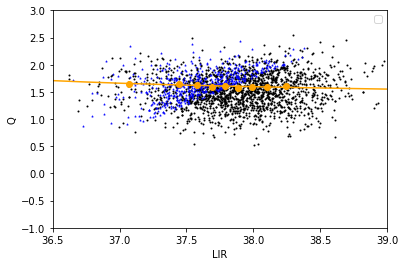

[ 1.7864694  -0.09989068] [[ 0.01088047 -0.00558471]
 [-0.00558471  0.00294178]]


In [249]:
#since i can recover the redshift evolution i put into the toy model i know want to know if this could appear 
#as a evolution with FIR luminosity

#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 


mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7) & (bethermin_table['SFR']>0)
z = bethermin_table['REDSHIFT'][mask_mass]
lir = bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26


alpha = -0.73
frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-alpha)) * 1E26 #get radio fluxes in Jy

mask_rad_sel = (frad>1E-4)  

q_det_orig = q[mask_rad_sel]
mask = ~np.isinf(q_det_orig)
q_det = q_det_orig[mask]



frad_lim = 1E-4 / 1E26
lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel]**2 * (1+z[~mask_rad_sel])**(-1-alpha))
q_lim_orig = np.log10(lir[~mask_rad_sel]/3.75E12) - np.log10(lrad_lim)
mask = ~np.isinf(q_lim_orig)
q_lim = q_lim_orig[mask]





mask = ~np.isinf(q_det_orig)
x = np.log10(lir[mask_rad_sel][mask])
y = q_det
plt.scatter(x,y,s=1,c='black')

mask = ~np.isinf(q_lim_orig)
x = np.log10(lir[~mask_rad_sel][mask])
y = q_lim
plt.scatter(x,y,s=1,marker='^',c='blue')






bins_lir = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_lir.append(np.percentile(lir,percent))
bins_lir = np.array(bins_lir)
print(bins_lir)


num = 10
N = int(len(q_det)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
N = int(len(q_lim)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append( np.ones(len(q_det[bootstrap_det[n]])), np.zeros(len(q_lim[bootstrap_lim[n]])) )
    
    lir_det = lir[mask_rad_sel][bootstrap_det[n]]
    
    lir_lim = lir[~mask_rad_sel][bootstrap_lim[n]]


    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    median_q.append(kmf.median_survival_time_)
    kmfs.append(kmf)


    tot_lir = np.append(lir_det,lir_lim)
    


    test = np.digitize(tot_lir,bins=bins_lir)
    nums_lir,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    lir_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_lir[:len(bins_lir)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        values_z = data[mask]
        detections_z = det[mask]

        lir_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(values_z, detections_z,label='Kaplan Meier Estimate')
        
        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_)
        median_q_err.append(err)
        
    x = np.log10(get_center(bins_lir))
    y = mean_q_agnfitter   
    popt,pcov = curve_fit(power_law,x-36,y,po,sigma=median_q_err)
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = np.log10(get_center(bins_lir))
y = medians
yerr = errs
plt.scatter(x,y,c='orange')
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,6,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = power_law(x,N_mean,alpha_mean)
plt.plot(x+36,y,c='orange')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')



plt.ylim(-1,3)
plt.xlim(36.5,39,5)
plt.xlabel('LIR')
plt.ylabel('Q')
plt.legend()
plt.show()

print(popt,pcov)

In [247]:
get_center(bins_lir)

array([1.17911897e+37, 2.76144812e+37, 3.79679950e+37, 4.89654380e+37,
       6.17095493e+37, 7.72376085e+37, 9.75700996e+37, 1.25184892e+38,
       1.75312711e+38, 1.29037397e+39])

[1.43674379e+36 2.21456356e+37 3.30833267e+37 4.28526632e+37
 5.50782127e+37 6.83408859e+37 8.61343311e+37 1.09005868e+38
 1.41363917e+38 2.09261505e+38 2.37148644e+39]


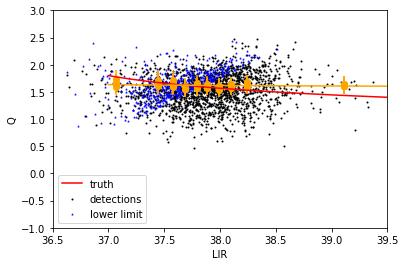

[ 1.63451222 -0.01452708] [[ 0.00631069 -0.00354149]
 [-0.00354149  0.00203807]]


In [254]:
#now try generating q values with an evolution with LIR

#since i can recover the redshift evolution i put into the toy model i know want to know if this could appear 
#as a evolution with FIR luminosity

#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 


mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7) & (bethermin_table['SFR']>0)
z = bethermin_table['REDSHIFT'][mask_mass]
lir = bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26

N = 1.8
alpha = -0.1
q = generate_q_z_evo(len(bethermin_table[mask_mass]),0.35,np.log10(lir)-36,N,alpha,dist_type='norm')
lrad = 10**(np.log10(lir/3.75E12) - q)


alpha = -0.73
frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-alpha)) * 1E26 #get radio fluxes in Jy

mask_rad_sel = (frad>1E-4)  

q_det_orig = q[mask_rad_sel]
mask = ~np.isinf(q_det_orig)
q_det = q_det_orig[mask]



frad_lim = 1E-4 / 1E26
lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel]**2 * (1+z[~mask_rad_sel])**(-1-alpha))
q_lim_orig = np.log10(lir[~mask_rad_sel]/3.75E12) - np.log10(lrad_lim)
mask = ~np.isinf(q_lim_orig)
q_lim = q_lim_orig[mask]





mask = ~np.isinf(q_det_orig)
x = np.log10(lir[mask_rad_sel][mask])
y = q_det
plt.scatter(x,y,s=1,label='detections',c='black')

mask = ~np.isinf(q_lim_orig)
x = np.log10(lir[~mask_rad_sel][mask])
y = q_lim
plt.scatter(x,y,s=1,marker='^',label='lower limit',c='blue')

N = 1.8
alpha = -0.2
x = np.arange(0,4,0.01)
y = power_law(x,N,alpha)
plt.plot(x+37,y,c='red',label='truth')




bins_lir = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_lir.append(np.percentile(lir,percent))
bins_lir = np.array(bins_lir)
print(bins_lir)


num = 10
N = int(len(q_det)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
N = int(len(q_lim)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)

median_q = []
kmfs = []
for n in range(num):
    data = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append( np.ones(len(q_det[bootstrap_det[n]])), np.zeros(len(q_lim[bootstrap_lim[n]])) )
    
    lir_det = lir[mask_rad_sel][bootstrap_det[n]]
    
    lir_lim = lir[~mask_rad_sel][bootstrap_lim[n]]


    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    median_q.append(kmf.median_survival_time_)
    kmfs.append(kmf)


    tot_lir = np.append(lir_det,lir_lim)
    


    test = np.digitize(tot_lir,bins=bins_lir)
    nums_lir,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    lir_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_lir[:len(bins_lir)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        values_z = data[mask]
        detections_z = det[mask]

        lir_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(values_z, detections_z,label='Kaplan Meier Estimate')
        
        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_)
        median_q_err.append(err)
        
    x = np.log10(get_center(bins_lir))
    y = mean_q_agnfitter
    plt.scatter(x,y,c='orange')
    yerr = median_q_err
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

popt,pcov = curve_fit(power_law,x-36,y,po,sigma=yerr)  

x = np.arange(0,4,0.001)
y = power_law(x,popt[0],popt[1])
plt.plot(x+37,y,c='orange')

plt.ylim(-1,3)
plt.xlim(36.5,39.5)
plt.xlabel('LIR')
plt.ylabel('Q')
plt.legend()
plt.show()

print(popt,pcov)

(array([  1.,  12.,  73., 269., 647., 738., 437., 125.,  18.,  11.]),
 array([0.15737933, 0.47914346, 0.80090759, 1.12267172, 1.44443586,
        1.76619999, 2.08796412, 2.40972825, 2.73149238, 3.05325651,
        3.37502065]),
 <a list of 10 Patch objects>)

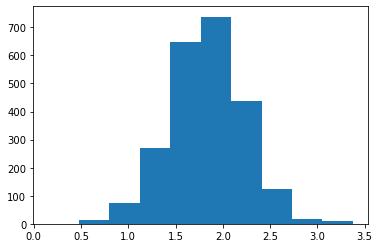

In [256]:
plt.hist(np.log10(lir)-36)

1772
559
[0.039728 0.414687 0.564041 0.648886 0.709765 0.768839 0.814024 0.869652
 0.91756  0.961784 0.999365]


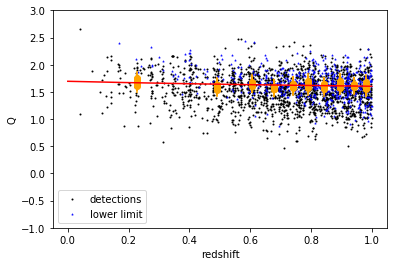

[ 1.69526371 -0.07981927] [[ 0.00350864 -0.00371488]
 [-0.00371488  0.00423666]]


In [257]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 


mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7) & (bethermin_table['SFR']>0)
z = bethermin_table['REDSHIFT'][mask_mass]
lir = bethermin_table['SFR'][mask_mass] / 1E-10 * 3.8E26




alpha = -0.73
frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-alpha)) * 1E26 #get radio fluxes in Jy

mask_rad_sel = (frad>1E-4)  

q_det_orig = q[mask_rad_sel]
mask = ~np.isinf(q_det_orig)
q_det = q_det_orig[mask]



frad_lim = 1E-4 / 1E26
lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel]**2 * (1+z[~mask_rad_sel])**(-1-alpha))
q_lim_orig = np.log10(lir[~mask_rad_sel]/3.75E12) - np.log10(lrad_lim)
mask = ~np.isinf(q_lim_orig)
q_lim = q_lim_orig[mask]



mask = ~np.isinf(q_det_orig)
x = z[mask_rad_sel][mask]
y = q_det
print(len(y))
plt.scatter(x,y,s=1,label='detections',c='black')

mask = ~np.isinf(q_lim_orig)
x = z[~mask_rad_sel][mask]
y = q_lim
print(len(y))
plt.scatter(x,y,s=1,marker='^',label='lower limit',c='blue')



redshifts = bethermin_table['REDSHIFT'][mask_mass]
bins_z = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
print(bins_z)


num = 10
N = int(len(q_det)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(q_det),1),num,samples=N).astype(int)
N = int(len(q_lim)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(q_lim),1),num,samples=N).astype(int)

median_q = []
kmfs = []
for n in range(num):
    data = np.append(q_det[bootstrap_det[n]],q_lim[bootstrap_lim[n]])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append( np.ones(len(q_det[bootstrap_det[n]])), np.zeros(len(q_lim[bootstrap_lim[n]])) )
    
    redshift_det = z[mask_rad_sel][bootstrap_det[n]]
    
    redshift_lim = z[~mask_rad_sel][bootstrap_lim[n]]


    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    median_q.append(kmf.median_survival_time_)
    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        values_z = data[mask]
        detections_z = det[mask]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(values_z, detections_z,label='Kaplan Meier Estimate')
        
        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_)
        median_q_err.append(err)
        
    x = get_center(bins_z)
    y = mean_q_agnfitter[:10]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:10]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)  

x = np.arange(0,1,0.001)
y = power_law(x,popt[0],popt[1])
plt.plot(x,y,c='red')
    
plt.ylim(-1,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()

print(popt,pcov)

11
144
476
546
626
767
918
901
832
738
there are 11 sources with z<0.1
there are 4 sources with z<0.1 and are detected in the radio 
values: [ 2.03579967 -0.14071283]
errors: [[ 0.01620378 -0.01533376]
 [-0.01533376  0.0160047 ]]
---------------------------------
there are 11 sources with z<0.1
there are 5 sources with z<0.1 and are detected in the radio 
values: [ 2.09045696 -0.21229969]
errors: [[ 0.00323543 -0.0029832 ]
 [-0.0029832   0.00303901]]
---------------------------------
there are 11 sources with z<0.1
there are 3 sources with z<0.1 and are detected in the radio 
values: [ 2.094767   -0.20786406]
errors: [[ 0.01121281 -0.01038331]
 [-0.01038331  0.01063423]]
---------------------------------
there are 11 sources with z<0.1
there are 5 sources with z<0.1 and are detected in the radio 
values: [ 2.09811966 -0.20245839]
errors: [[ 0.01477256 -0.01355748]
 [-0.01355748  0.01378945]]
---------------------------------
there are 11 sources with z<0.1
there are 4 sources with z<0.

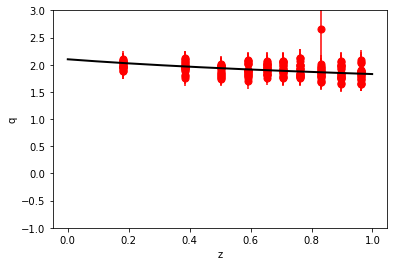

2.057636898240715
-0.16354410199771466


In [189]:
z = bethermin_table['REDSHIFT']
lir = bethermin_table['SFR'] / 1E-10 * 3.8E26

mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7)
redshifts_use = z[mask_mass]
lir_use = lir[mask_mass]
dist_use = dist[mask_mass]

bins_z = np.arange(0,1.1,0.1)
z = []
lir = []
dist_use_here = []
for n in range(len(bins_z)-1):
    mask_z = (redshifts_use>bins_z[n]) & (redshifts_use<bins_z[n+1])
    redshifts_in_bin = redshifts_use[mask_z]
    lir_in_bin = lir_use[mask_z]
    dist_in_bin = dist_use[mask_z]
    
    num_in_z_bin_lofar = np.sum( (detected_sample_en1['Z_BEST']>bins_z[n]) & (detected_sample_en1['Z_BEST']<bins_z[n+1]) )
    #generate random sampling of the redshifts in the bin
    print(num_in_z_bin_lofar)
    num_random = []
    for m in range(num_in_z_bin_lofar):
        N = randint(0,np.sum(mask_z))-1
        z.append(redshifts_in_bin[N])
        lir.append(lir_in_bin[N])
        dist_use_here.append(dist_in_bin[N])
        
z = np.array(z)
lir = np.array(lir)
dist_use_here = np.array(dist_use_here)
        

params = np.arange(-0.5,0,0.1)
median_q_z = []
measured_N = []
measured_a = []
for m,param in enumerate(np.arange(0,20,1)):
    N = 2.1
    q = generate_q_z_evo(len(lir),0,z,N,-0.2,dist_type='norm')
    lrad = 10**(np.log10(lir/3.75E12) - q)

    alpha = -0.73
    frad = lrad/(4*np.pi*dist_use_here**2 * (1+z)**(-1-alpha)) * 1E26 #get radio fluxes in Jy


    mask_rad_sel = (frad>1E-4)  

    q_det = q[mask_rad_sel]

    frad_lim = 1E-4 / 1E26
    lrad_lim = frad_lim * (4*np.pi*dist_use_here[~mask_rad_sel]**2 * (1+z[~mask_rad_sel])**(-1-alpha))
    q_lim = np.log10(lir[~mask_rad_sel]/3.75E12) - np.log10(lrad_lim)

    data = np.append(q_det,q_lim)
    mask = ~np.isinf(data)
    data = data[mask]
    det = np.append(np.ones(len(q_det)),np.zeros(len(q_lim)))[mask]
    print('there are {} sources with z<0.1'.format(np.sum(z<0.1)))
    print('there are {} sources with z<0.1 and are detected in the radio '.format(np.sum(z[mask_rad_sel]<0.1)))
    data_z = np.append(z[mask_rad_sel],z[~mask_rad_sel])[mask]
    kmf = KaplanMeierFitter() 
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    bins_z = np.arange(0,1,0.1)

    
    test = np.digitize(data_z,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    median_q = []
    median_q_err = []
    for n,num in enumerate(nums_z):
        mask_z = test == num
        data_tmp = data[mask_z]
        det_tmp = det[mask_z]
        if len(data_tmp)==0:
            median_q.append(np.nan)
            continue
        kmf = KaplanMeierFitter() 
        kmf.fit(data_tmp, det_tmp,label='Kaplan Meier Estimate')
        
        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(data_tmp[det_tmp.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(data_tmp[~det_tmp.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()
        
        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        median_q.append(kmf.median_survival_time_)
        median_q_err.append(err)
    
    x = bins_z+0.05
    y = np.array(median_q)
    yerr = np.array(median_q_err)
    mask = (~np.isnan(y)) & (~np.isinf(y))
    x = x[mask]
    y = y[mask]
    yerr = yerr[mask]
    plt.scatter(x,y,c='red',s=50)
    plt.errorbar(x,y,yerr,c='red',linestyle='')
    po = [1.7,-0.2]
    popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
    x = np.arange(0,1,0.001)
    y = power_law(x,popt[0],popt[1])
    #plt.plot(x,y,c='red',alpha=1)
    print('values: {}'.format(popt))
    print('errors: {}'.format(pcov))
    print('---------------------------------')
    measured_N.append(popt[0])
    measured_a.append(popt[1])
    median_q_z.append(median_q)

#plot my fit the data on top of the estimates
x = np.arange(0,1,0.001)
y = power_law(x,2.1,-0.2)
plt.plot(x,y,c='black',linewidth=2)

plt.xlabel('z')
plt.ylabel('q')
plt.ylim(-1,3)
plt.show()

print(np.mean(measured_N))
print(np.mean(measured_a))






In [167]:
z[z<0.1]

array([0.078122, 0.066901, 0.078153, 0.078153, 0.040151, 0.078122,
       0.067105, 0.067105, 0.078153, 0.078153, 0.067105])

[ 1.65635738 -0.12380994]


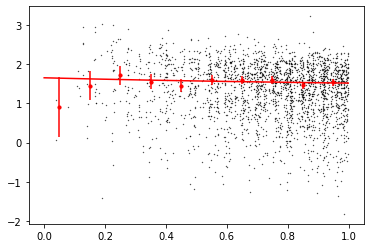

In [92]:
x = data_z
y = data
plt.scatter(x,y,c='black',s=0.1)

x = bins_z+0.05
y = median_q
plt.scatter(x,y,c='red',s=10)

x = bins_z+0.05
y = median_q
plt.errorbar(x,y,median_q_err,c='red',linestyle='')

popt,pcov = curve_fit(power_law,x[2:],y[2:],po,sigma=median_q_err[2:])
print(popt)
x = np.arange(0,1,0.001)
y = power_law(x,popt[0],popt[1])
plt.plot(x,y,c='red',alpha=1)


In [85]:
x = bins_z+0.05
y = median_q
popt,pcov = curve_fit(power_law,x,y,po,sigma=median_q_err)
popt

array([ 1.7089435 , -0.28517838])

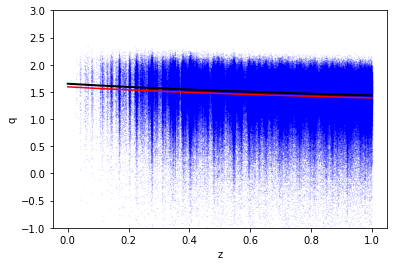

1.593202823074649
-0.19720005139545457


In [341]:
params = np.arange(-0.5,0,0.1)
measured_N = []
measured_a = []

N = 1.65
q = generate_q_z_evo(len(lir),0.4,z,N,-0.2,dist_type='lognorm')
lrad = 10**(np.log10(lir/3.75E12) - q)

alpha = -0.73
frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-alpha)) * 1E26 #get radio fluxes in Jy

mask_mass = (bethermin_table['REDSHIFT']<1.0)
mask_rad_sel = (frad>1E-4)  

q_det = q[mask_mass]

frad_lim = 1E-4 / 1E26
lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel & mask_mass]**2 * (1+z[~mask_rad_sel & mask_mass])**(-1-alpha))
#q_lim = np.log10(lir[~mask_rad_sel & mask_mass]/3.75E12) - np.log10(lrad_lim)
q_lim = [0]

data = q_det
mask = ~np.isinf(data)
data = data[mask]
det = np.ones(len(q_det))[mask]
data_z = z[mask_mass][mask]
kmf = KaplanMeierFitter() 
kmf.fit(data, det,label='Kaplan Meier Estimate')

plt.scatter(data_z,data,c='blue',s=0.1,alpha=0.1)

bins_z = np.arange(0,1,0.1)
test = np.digitize(data_z,bins=bins_z)
nums_z,counts = np.unique(test,return_counts=True)

median_q = []
median_q_err = []
for n,num in enumerate(nums_z):
    mask_z = test == num
    data_tmp = data[mask_z]
    det_tmp = det[mask_z]
    if len(data_tmp)==0:
        median_q.append(np.nan)
        continue
    kmf = KaplanMeierFitter() 
    kmf.fit(data_tmp, det_tmp,label='Kaplan Meier Estimate')

    x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
    x = np.arange(-1,3,0.01)

    lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
    lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
    upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
    upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

    err = upx-lowx

    median_q.append(kmf.median_survival_time_)
    median_q_err.append(err)

x = bins_z+0.05
y = median_q
po = [2,-0.2]
popt,pcov = curve_fit(power_law,x,y,po,sigma=median_q_err)
x = np.arange(0,1,0.001)
y = power_law(x,popt[0],popt[1])
plt.plot(x,y,c='red')

measured_N.append(popt[0])
measured_a.append(popt[1])

#plot my fit the data on top of the estimates
x = np.arange(0,1,0.001)
y = power_law(x,1.65,-0.2)
plt.plot(x,y,c='black',linewidth=2)

plt.xlabel('z')
plt.ylabel('q')
plt.ylim(-1,3)
plt.show()

print(np.mean(measured_N))
print(np.mean(measured_a))






skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped


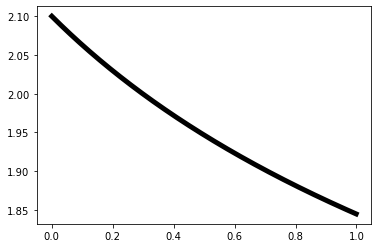

nan
nan


In [157]:
params = np.arange(-0.5,0,0.1)
measured_N = []
measured_a = []
for n,param in enumerate(np.arange(0,20,1)):
    N = 2
    q = generate_q_z_evo(len(lir),0.4,z,N,-0.2,dist_type='lognorm')
    lrad = 10**(np.log10(lir/3.75E12) - q)

    alpha = -0.73
    frad = lrad/(4*np.pi*dist**2 * (1+z)**(-1-alpha)) * 1E26 #get radio fluxes in Jy

    mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7)
    mask_rad_sel = (frad>6E-4) 

    q_det = q[mask_rad_sel]

    frad_lim = 1E-4 / 1E26
    lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel]**2 * (1+z[~mask_rad_sel])**(-1-alpha))
    q_lim = np.log10(lir[~mask_rad_sel]/3.75E12) - np.log10(lrad_lim)

    data = np.append(q_det,q_lim)
    mask = (~np.isinf(data)) & (~np.isnan(data)) 
    data = data[mask]
    det = np.append(np.ones(len(q_det)),np.zeros(len(q_lim)))[mask]
    data_z = np.append(z[ mask_rad_sel],z[ ~mask_rad_sel])[mask]
    kmf = KaplanMeierFitter() 
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    bins_z = np.arange(0,1,0.1)
    test = np.digitize(data_z,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    median_q = []
    for n,num in enumerate(nums_z):
        mask_z = test == num
        data_tmp = data[mask_z]
        det_tmp = det[mask_z]
        if len(data_tmp)==0:
            median_q.append(np.nan)
            continue
        kmf = KaplanMeierFitter() 
        kmf.fit(data_tmp, det_tmp,label='Kaplan Meier Estimate')
    
        median_q.append(kmf.median_survival_time_)
    median_q = np.array(median_q)
    mask = ~np.isinf(median_q)
    if np.sum(mask)<2:
        print('skipped')
        continue
    x = bins_z[mask] + 0.05
    y = median_q[mask]
    po = [2,-0.2]
    popt,pcov = curve_fit(power_law,x,y,po)
    x = np.arange(0,1,0.001)
    y = power_law(x,popt[0],popt[1])
    plt.plot(x,y,c='red')
    
    measured_N.append(popt[0])
    measured_a.append(popt[1])

#plot my fit the data on top of the estimates
x = np.arange(0,1,0.001)
y = power_law(x,2.1,-0.187)
plt.plot(x,y,c='black',linewidth=5)
plt.show()

print(np.mean(measured_N))
print(np.mean(measured_a))






In [156]:
np.sum(mask)

0

There are 6043 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 19682 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


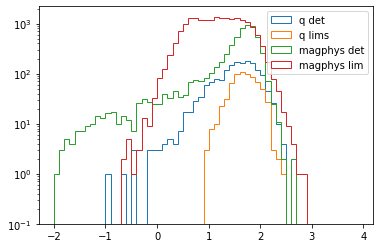

In [93]:
#check the simulated q distribution is similar to the magphys q
mask_mass = (bethermin_table['REDSHIFT']<1.0) & (np.log10(bethermin_table['MSTAR'])>10.7)
mask_rad_sel = (frad>1E-4)  

bins = np.arange(-2,4,0.1)
q_det = q[mask_rad_sel & mask_mass]
plt.hist(q_det,bins=bins,log=True,histtype='step',label='q det')

frad_lim = 1E-4 / 1E26
lrad_lim = frad_lim * (4*np.pi*dist[~mask_rad_sel & mask_mass]**2 * (1+z[~mask_rad_sel & mask_mass])**(-1-alpha))
q_lim = np.log10(lir[~mask_rad_sel & mask_mass]/3.75E12) - np.log10(lrad_lim)
plt.hist(q_lim,bins=bins,log=True,histtype='step',label='q lims')

#plot the magphys q's
#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (lofar_sed_en1['Mass_median']>10.7)
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(np.sum(mask_mass_complete_en1)))
detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1]

mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (lofar_magphys_en1['Mass_median']>10.7)
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(np.sum(mask_mass_complete_limit_en1)))
limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1]

y = detected_sample_en1['q_magphys']
plt.hist(y,bins=bins,log=True,histtype='step',label='magphys det')

y = limit_sample_en1['q_lim']
plt.hist(y,bins=bins,log=True,histtype='step',label='magphys lim')

plt.legend()
plt.show()